# Example of the SASRec training and inference stages
Note that all the given examples can be run without using PySpark, using only Pandas

In [1]:
# changing core directory
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('..')

In [2]:
import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import torch

from replay_main.metrics import OfflineMetrics, Recall, Precision, MAP, NDCG, HitRate, MRR
from replay_main.metrics.torch_metrics_builder import metrics_to_df
from replay_main.splitters import LastNSplitter
from replay_main.utils import get_spark_session
from replay_main.data import (
    FeatureHint,
    FeatureInfo,
    FeatureSchema,
    FeatureSource,
    FeatureType,
    Dataset,
)
from replay_main.models.nn.optimizer_utils import FatOptimizerFactory
from replay_main.models.nn.sequential.callbacks import (
    ValidationMetricsCallback,
    SparkPredictionCallback,
    PandasPredictionCallback, 
    TorchPredictionCallback,
    QueryEmbeddingsPredictionCallback
)
from replay_main.models.nn.sequential.postprocessors import RemoveSeenItems
from replay_main.data.nn import (
    SequenceTokenizer,
    SequentialDataset,
    TensorFeatureSource,
    TensorSchema,
    TensorFeatureInfo
)
from replay_main.models.nn.sequential import SasRec
from replay_main.models.nn.sequential.sasrec import (
    SasRecPredictionDataset,
    SasRecTrainingDataset,
    SasRecValidationDataset,
    SasRecPredictionBatch,
    SasRecModel
)

import pandas as pd
import matplotlib.pyplot as plt

## Getting a spark session

In [3]:
spark_session = get_spark_session()

/usr/local/lib/python3.11/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/22 14:37:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/22 14:37:33 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/11/22 14:37:34 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Prepare data
### Load raw movielens-1M interactions, item features and user features.
In the current implementation, the SASRec does not take into account the features of items or users. They are only used to get a complete list of users and items.

In [4]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("data/zvuk-dataset")

# print("Path to dataset files:", path)

# Путь к файлу
path = "data/zvuk-interactions.parquet"

# Загрузка данных
interactions = pd.read_parquet(path)
interactions = interactions.sample(int(1e+6), random_state=42)
interactions = interactions.rename(columns={'track_id': 'item_id'})

user_map = {user_id: idx for idx, user_id in enumerate(interactions['user_id'].unique())}
item_map = {item_id: idx for idx, item_id in enumerate(interactions['item_id'].unique())}

interactions['user_id'] = interactions['user_id'].map(user_map)
interactions['item_id'] = interactions['item_id'].map(item_map)

interactions.head()

,user_id,session_id,datetime,item_id,play_duration
61355373,0,6624337,2023-03-19 03:07:36.517,0,94.000000
63451678,1,2080247,2023-05-06 10:03:39.468,1,4.999992
175277420,2,10969639,2023-04-21 04:46:10.901,2,52.000000
119370813,3,10954583,2023-03-07 07:47:43.190,3,199.000000
47555552,4,837825,2023-04-07 02:46:27.078,4,-0.000008


In [5]:
interactions['play_duration'] = abs(interactions['play_duration'])
interactions['relevance'] = (interactions['play_duration'] > 10).astype(int)

In [6]:
interactions['play_duration'].describe()

count    1000000.000000
mean         102.074020
std          101.522217
min            0.000008
25%            2.999992
50%           78.000000
75%          187.000000
max         7921.000488
Name: play_duration, dtype: float64

<Axes: >

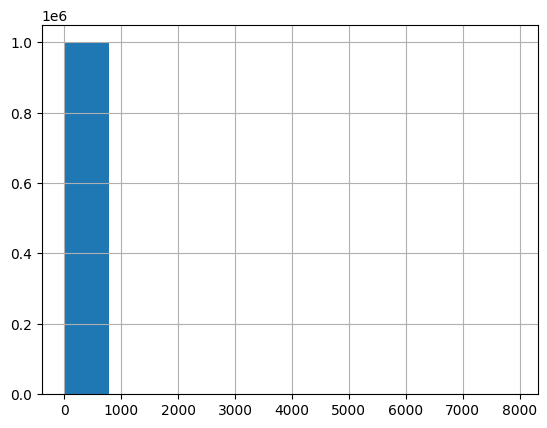

In [7]:
interactions['play_duration'].hist()

In [8]:
# movielens = MovieLens("1m")
# interactions = movielens.ratings
# user_features = movielens.users
# item_features = movielens.items

In [9]:
interactions.groupby('user_id').count().mean()

session_id       5.329524
datetime         5.329524
item_id          5.329524
play_duration    5.329524
relevance        5.329524
dtype: float64

Removing duplicates in the timestamp column without changing the original items order where timestamp is the same

In [10]:
interactions["timestamp"] = interactions["datetime"].astype("int64")
interactions = interactions.sort_values(by="timestamp")
interactions["timestamp"] = interactions.groupby("user_id").cumcount()
interactions 

,user_id,session_id,datetime,item_id,play_duration,relevance,timestamp
225127421,14249,9766787,2023-01-15 00:00:27.283,12648,128.000000,1,0
216799242,32503,2338941,2023-01-15 00:01:15.603,65066,147.000000,1,0
53000263,26338,6739573,2023-01-15 00:01:45.217,119301,1.000008,0,0
22201544,9657,6176457,2023-01-15 00:02:03.919,10862,0.000008,0,0
62774150,54518,1622227,2023-01-15 00:02:31.455,4578,268.000000,1,0
...,...,...,...,...,...,...,...
28574597,23928,1486433,2023-05-14 20:58:38.042,930,13.999992,1,6
74205579,90936,11865782,2023-05-14 20:58:51.341,162603,197.000000,1,7
193342693,25257,3251792,2023-05-14 20:58:54.373,49635,148.000000,1,20
216900734,73933,6279427,2023-05-14 20:58:56.895,2601,175.000000,1,6


In [11]:
interactions = interactions[['user_id', 'item_id', 'timestamp', 'relevance']]
interactions.head()

,user_id,item_id,timestamp,relevance
225127421,14249,12648,0,1
216799242,32503,65066,0,1
53000263,26338,119301,0,0
22201544,9657,10862,0,0
62774150,54518,4578,0,1


### Split interactions into the train, validation and test datasets using LastNSplitter

In [12]:
splitter = LastNSplitter(
    N=1,
    divide_column="user_id",
    query_column="user_id",
    strategy="interactions",
)

raw_test_events, raw_test_gt = splitter.split(interactions)
raw_validation_events, raw_validation_gt = splitter.split(raw_test_events)
raw_train_events = raw_validation_events

### Prepare FeatureSchema required to create Dataset

In [13]:
def prepare_feature_schema(is_ground_truth: bool) -> FeatureSchema:
    base_features = FeatureSchema(
        [
            FeatureInfo(
                column="user_id",
                feature_hint=FeatureHint.QUERY_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
            FeatureInfo(
                column="item_id",
                feature_hint=FeatureHint.ITEM_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
        ]
    )
    if is_ground_truth:
        return base_features

    all_features = base_features + FeatureSchema(
        [
            FeatureInfo(
                column="timestamp",
                feature_type=FeatureType.NUMERICAL,
                feature_hint=FeatureHint.TIMESTAMP,
            ),
        ]
    )
    return all_features

### Create Dataset for the training stage

In [14]:
train_dataset = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=False),
    interactions=raw_train_events,
    check_consistency=True,
    categorical_encoded=False,
)

### Create Datasets (events and ground_truth) for the validation stage

In [15]:
validation_dataset = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=False),
    interactions=raw_validation_events,
    check_consistency=True,
    categorical_encoded=False,
)
validation_gt = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=True),
    interactions=raw_validation_gt,
    check_consistency=True,
    categorical_encoded=False,
)

### Create Datasets (events and ground_truth) for the testing stage

In [16]:
test_dataset = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=False),
    interactions=raw_test_events,
    check_consistency=True,
    categorical_encoded=False,
)
test_gt = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=True),
    interactions=raw_test_gt,
    check_consistency=True,
    categorical_encoded=False,
)

### Create the tensor schema
A schema shows the correspondence of columns from the source dataset with the internal representation of tensors inside the model

In [17]:
ITEM_FEATURE_NAME = "item_id_seq"

tensor_schema = TensorSchema(
    TensorFeatureInfo(
        name=ITEM_FEATURE_NAME,
        is_seq=True,
        feature_type=FeatureType.CATEGORICAL,
        feature_sources=[TensorFeatureSource(FeatureSource.INTERACTIONS, train_dataset.feature_schema.item_id_column)],
        feature_hint=FeatureHint.ITEM_ID,
    )
)

### Create sequential datasets using SequenceTokenizer
The SequentialDataset internally store data in the form of sequences of items sorted by increasing interaction time (timestamp). A SequenceTokenizer is used to convert to this format. In addition, the SequenceTokenizer encodes all categorical columns from the source dataset and stores mapping inside itself.
SequentialDataset.keep_common_query_ids is used to leave only sequences from the same users

In [18]:
tokenizer = SequenceTokenizer(tensor_schema, allow_collect_to_master=True)
tokenizer.fit(train_dataset)

sequential_train_dataset = tokenizer.transform(train_dataset)

sequential_validation_dataset = tokenizer.transform(validation_dataset)
sequential_validation_gt = tokenizer.transform(validation_gt, [tensor_schema.item_id_feature_name])

sequential_validation_dataset, sequential_validation_gt = SequentialDataset.keep_common_query_ids(
    sequential_validation_dataset, sequential_validation_gt
)

ValueError: Found unknown labels [2, 162656, 10, 28754, 139221, 100757, 106346, 130136, 149847, 65, 47791, 90046, 88, 103426, 98, 134602, 78503, 190533, 6903, 138, 192512, 74624, 158721, 26842, 181246, 110703, 39137, 124378, 102474, 68220, 175508, 92242, 29052, 41584, 194341, 235, 141336, 253, 81106, 170967, 121170, 196100, 188853, 184322, 194263, 85688, 103585, 118018, 65157, 74864, 28605, 351, 29704, 51961, 182614, 101502, 169194, 378, 153138, 133252, 35556, 403, 181771, 103498, 80801, 166151, 58658, 141623, 189281, 100283, 78226, 83362, 454, 87114, 156552, 64678, 84927, 139321, 67131, 171926, 515, 52541, 142994, 17711, 23718, 102119, 180335, 63154, 173264, 45973, 115507, 153082, 28823, 89355, 45924, 166903, 64726, 191892, 655, 27544, 190964, 157973, 153048, 162160, 102077, 94368, 153067, 125902, 145816, 41961, 9215, 171549, 171283, 141078, 92650, 178580, 30511, 43059, 132711, 180149, 3626, 117989, 94597, 51668, 32595, 85005, 195648, 881, 173602, 908, 196524, 118600, 196977, 119636, 158187, 70701, 943, 160409, 192631, 968, 183871, 164020, 155073, 51327, 996, 150503, 87818, 178231, 84271, 151530, 1055, 3098, 161633, 117557, 55377, 144498, 130621, 123091, 75147, 111645, 78213, 32002, 153738, 194521, 82553, 147467, 169088, 180412, 138121, 122919, 124225, 106162, 118300, 90718, 13049, 173420, 24044, 129443, 1281, 196365, 196575, 123435, 11160, 1335, 1340, 144651, 199488, 103165, 21067, 133756, 61010, 1398, 1402, 63076, 107966, 168071, 136767, 154130, 22790, 64936, 1435, 148647, 1456, 34502, 1460, 130626, 181360, 128671, 6648, 163110, 64842, 44576, 1502, 174607, 167361, 67339, 72011, 179528, 86240, 29850, 61560, 137048, 196838, 198199, 164000, 109383, 193397, 79766, 135154, 111892, 73823, 54107, 1601, 60709, 135066, 56778, 1627, 1630, 92533, 168999, 57444, 192430, 177255, 101580, 5207, 76621, 175320, 102063, 178410, 35307, 137838, 3424, 123887, 1734, 149585, 22210, 88256, 143780, 196871, 102429, 192085, 30526, 192845, 79311, 48433, 122926, 59622, 120960, 43278, 82974, 1848, 86126, 105111, 141863, 98341, 159590, 172832, 53348, 181623, 106658, 143341, 144844, 106326, 198939, 121373, 104268, 154005, 74331, 199649, 1987, 36377, 199668, 112382, 104545, 33338, 148069, 92201, 2043, 167765, 110259, 175398, 30110, 88265, 137672, 185500, 146996, 111897, 156139, 129125, 110820, 185832, 24617, 188352, 2161, 16413, 95421, 195916, 121359, 84239, 153703, 66095, 151898, 186868, 72497, 98262, 2250, 123173, 126870, 164166, 106912, 5684, 178621, 115886, 119383, 2289, 169317, 52745, 199140, 146385, 185442, 23004, 163416, 198383, 58498, 177462, 111002, 65013, 170036, 153159, 79239, 58595, 125928, 2404, 2414, 190923, 91573, 154139, 177269, 37117, 27649, 92446, 93961, 148124, 186521, 77336, 3221, 192229, 48424, 151707, 165687, 141156, 50548, 15363, 118508, 109882, 169601, 74089, 154151, 124819, 190872, 198740, 113869, 53767, 123578, 141443, 2569, 2573, 177568, 74184, 87024, 173849, 171858, 129112, 2674, 162562, 18313, 114053, 34037, 174863, 91308, 20390, 97301, 117297, 85249, 2740, 73013, 134771, 154642, 180840, 171117, 90057, 148847, 57194, 192593, 174545, 116335, 16041, 160548, 139777, 149639, 142501, 48413, 81965, 171636, 2905, 2908, 198606, 92716, 111257, 36257, 187901, 2925, 182030, 2938, 115243, 41954, 100147, 13860, 127704, 2961, 21425, 2966, 79335, 190395, 121358, 63591, 118114, 76674, 107523, 128010, 146167, 162228, 83456, 74717, 157806, 108320, 154788, 160324, 96656, 147452, 157366, 180843, 147091, 144831, 3124, 176750, 190592, 94399, 77625, 181228, 16744, 29969, 123456, 92214, 79369, 36305, 82171, 3163, 21860, 145028, 149396, 126934, 147432, 156535, 3205, 133060, 166954, 138591, 3219, 173541, 141028, 3230, 147991, 8531, 126256, 36978, 100642, 125639, 128992, 189232, 172831, 180446, 127453, 188901, 179910, 12773, 81101, 157363, 132707, 175220, 3337, 108910, 161657, 194990, 89490, 79394, 182391, 192600, 112461, 199217, 149636, 116297, 121878, 89943, 77390, 164463, 35882, 193988, 103133, 140018, 146758, 28041, 67108, 185666, 104159, 3504, 139199, 101939, 54596, 14377, 165778, 20123, 120497, 150290, 3549, 195841, 156845, 3581, 125821, 147762, 3617, 193561, 106078, 138997, 144425, 51434, 143512, 81988, 179123, 149550, 131416, 131696, 3710, 119573, 142320, 36196, 47891, 38765, 185527, 130939, 170602, 170813, 58935, 3783, 3798, 33850, 150608, 3808, 159098, 135844, 195565, 135443, 98369, 122840, 3854, 14248, 22102, 27587, 71752, 171360, 165483, 78744, 98678, 79869, 111748, 196182, 104779, 74438, 39619, 132325, 27585, 198044, 82940, 93043, 113941, 144766, 96654, 191282, 180449, 139365, 44269, 141776, 4050, 68412, 84297, 145375, 34481, 10505, 128354, 173204, 61138, 4127, 32986, 200125, 27213, 154794, 98659, 4153, 163838, 190440, 150942, 136872, 129660, 177284, 199392, 106576, 150218, 4260, 138292, 4279, 194585, 113241, 163026, 166580, 128702, 172960, 193039, 77325, 4343, 167549, 170919, 100733, 109341, 175480, 190726, 88680, 4392, 102097, 152936, 194139, 170990, 162794, 186860, 68829, 194183, 26906, 173545, 4465, 129845, 175351, 57587, 155885, 86485, 186446, 27083, 16588, 181247, 48874, 141996, 4529, 4531, 107766, 57300, 57058, 65218, 31382, 4580, 80357, 139500, 27832, 4629, 116401, 4644, 106739, 103496, 111315, 76189, 4699, 84773, 87620, 147892, 66583, 80108, 70938, 116620, 183099, 4733, 169406, 181785, 180157, 64766, 103316, 165824, 169932, 166908, 177111, 173366, 132021, 199605, 130250, 194506, 108386, 13660, 151861, 39950, 161746, 94752, 97874, 116890, 50349, 135821, 150511, 4875, 151563, 175731, 4885, 197235, 170399, 179459, 199102, 97193, 195781, 137209, 56690, 103321, 118298, 97633, 146538, 90480, 4990, 115994, 105470, 192656, 5015, 5019, 15607, 151872, 183445, 37867, 112360, 72851, 108988, 179737, 182862, 42226, 107544, 114927, 63855, 108809, 23589, 25654, 107850, 166520, 83922, 5155, 197165, 5174, 150760, 196631, 131978, 117189, 5229, 5231, 90841, 33035, 167304, 100654, 105047, 5288, 91242, 97755, 143676, 199718, 94535, 69974, 5330, 103896, 33087, 112384, 147711, 181462, 5359, 68375, 197604, 120668, 32581, 175672, 136157, 166721, 193238, 131480, 161977, 71291, 89197, 33538, 94771, 116622, 196834, 117413, 121832, 5516, 186439, 36694, 113446, 148613, 163017, 134465, 173309, 109770, 179051, 139514, 118182, 135329, 188831, 5609, 135067, 122509, 5629, 130132, 74868, 5638, 138416, 70427, 5653, 131735, 197438, 41242, 94838, 128041, 5683, 184741, 5692, 19669, 192802, 144879, 132340, 95064, 5723, 112744, 45668, 145928, 5763, 187841, 109220, 5775, 185964, 5790, 65237, 156928, 143159, 167880, 184266, 131191, 193076, 100289, 118257, 165680, 118949, 102476, 93742, 42683, 113090, 5901, 67851, 41894, 45283, 182084, 112084, 5924, 5925, 113554, 160877, 5942, 5950, 162146, 41568, 5982, 117021, 84598, 184791, 57499, 105141, 91022, 140013, 29612, 185312, 66868, 111049, 13214, 155200, 8092, 97814, 18897, 69872, 140176, 66718, 18434, 113140, 178073, 81068, 122860, 62696, 58528, 187803, 6086, 33252, 128523, 168128, 143059, 18519, 128925, 6404, 61329, 6163, 127923, 78838, 57566, 183176, 172313, 159328, 174967, 149653, 62542, 38049, 6231, 67753, 104560, 21331, 149134, 161694, 137875, 189429, 138427, 117980, 156419, 6308, 77668, 6335, 153521, 68515, 6351, 109604, 160486, 156777, 149361, 166208, 98974, 89912, 54224, 192336, 166258, 6441, 150682, 64338, 18179, 145786, 38972, 6483, 179629, 76169, 40395, 89983, 76679, 178305, 6546, 156165, 6564, 46501, 99492, 102527, 16287, 186229, 6594, 170517, 158963, 199955, 157248, 113129, 6073, 197517, 6665, 6673, 121546, 138036, 6683, 171229, 161810, 6693, 23782, 138016, 33954, 6710, 175184, 165726, 59618, 175455, 175117, 196869, 163563, 6755, 155950, 198280, 166049, 27118, 189322, 157697, 98825, 99395, 153866, 157249, 6878, 81748, 162888, 65671, 185226, 84516, 161606, 114735, 97554, 162548, 154264, 197182, 22986, 167192, 69752, 196677, 6961, 185816, 191565, 158576, 117895, 97269, 7016, 7022, 7039, 103890, 7053, 173061, 124437, 41709, 151776, 144419, 134197, 60550, 197727, 183805, 184713, 89525, 64266, 190955, 149517, 7143, 86601, 134361, 81677, 152995, 158074, 39671, 38574, 62517, 115221, 154044, 100938, 70596, 171400, 167536, 30301, 7239, 137406, 149698, 182826, 106382, 7264, 147440, 104375, 192950, 46557, 134179, 101696, 190900, 14324, 176577, 175459, 113391, 88570, 34513, 110289, 188854, 30131, 135210, 161912, 7371, 155191, 172045, 120162, 88205, 7403, 166684, 7419, 88316, 11255, 181392, 7434, 119538, 132773, 153673, 130017, 159866, 102295, 147633, 7467, 45664, 173718, 159684, 128681, 194782, 104984, 146620, 167147, 157099, 109678, 74673, 96482, 175379, 167794, 176019, 12533, 32219, 4200, 178742, 35655, 63327, 23831, 37513, 95116, 162236, 7641, 53552, 131887, 141157, 7678, 160042, 106426, 7692, 183725, 32940, 76100, 180673, 169936, 107602, 51123, 130128, 181689, 59681, 18670, 94169, 110324, 129701, 7752, 68568, 177370, 189991, 100443, 106499, 193835, 13417, 147523, 175849, 7794, 130575, 182227, 88996, 191164, 12808, 58752, 191239, 110126, 168006, 149252, 137294, 102955, 79624, 169280, 129500, 115079, 180936, 128265, 173929, 18384, 170483, 176680, 43573, 46582, 7947, 106712, 95630, 65206, 47661, 7980, 99253, 156315, 174336, 107703, 159091, 46978, 142867, 157602, 179867, 150277, 126252, 180076, 8085, 197621, 198649, 103259, 170347, 124488, 114898, 125827, 102128, 8143, 195950, 156155, 136746, 56407, 51326, 8191, 181356, 62021, 127066, 191668, 187070, 152632, 143741, 120210, 92736, 103409, 136500, 174420, 8256, 156068, 114811, 8275, 148623, 149938, 45636, 8847, 191293, 84921, 14810, 184370, 140518, 11969, 8343, 104248, 148133, 168098, 104003, 184586, 96113, 102537, 172950, 123970, 199083, 194099, 146747, 83800, 148973, 78298, 169520, 196371, 21342, 200036, 52475, 8434, 170636, 8438, 173914, 98548, 133786, 131109, 110609, 159277, 121094, 153937, 177137, 125574, 151607, 54324, 192173, 154860, 187507, 61920, 8525, 8533, 155119, 147995, 8541, 104909, 69141, 29014, 187531, 189082, 90325, 95481, 74567, 59002, 129616, 190628, 134910, 138645, 37067, 156707, 13747, 184784, 178156, 50011, 94641, 127210, 101146, 146928, 183037, 8724, 134816, 85773, 124465, 102629, 136063, 109874, 8785, 197380, 8793, 120450, 199230, 8814, 161847, 161129, 8824, 128727, 156222, 165400, 160885, 148970, 71449, 134715, 8899, 180710, 121757, 111611, 104613, 83179, 56746, 51656, 175994, 101325, 81401, 158362, 117708, 191441, 49620, 171006, 185659, 113381, 108740, 166214, 134707, 15704, 199844, 105676, 78532, 138195, 9046, 179124, 186494, 185520, 143901, 127336, 99553, 164795, 64138, 176665, 175343, 185215, 73559, 82429, 37331, 187440, 9106, 9110, 181007, 197912, 101786, 9157, 185274, 109917, 122024, 152967, 66176, 88357, 196145, 30133, 146462, 142035, 150188, 9212, 66738, 50331, 158787, 47885, 9230, 143290, 76763, 193832, 111026, 158053, 101824, 79968, 182103, 9278, 185528, 9296, 160288, 196328, 129502, 137426, 9315, 65499, 195265, 142469, 26036, 150697, 18280, 9332, 199077, 100281, 120485, 9352, 37087, 178684, 130359, 9370, 81562, 156672, 9392, 31890, 140591, 142619, 9421, 9426, 33044, 111848, 130505, 9453, 196555, 70455, 188486, 167144, 148769, 136480, 188603, 180803, 148870, 58269, 185343, 9536, 93138, 107108, 171837, 158857, 66558, 89537, 159737, 9581, 9582, 135850, 133049, 162663, 157041, 158472, 9594, 149218, 168757, 156693, 181308, 193177, 85287, 9661, 170214, 160830, 177500, 85619, 87968, 140365, 166187, 105795, 151449, 102207, 112855, 9741, 40760, 105062, 9762, 9770, 9771, 125169, 96494, 122833, 192034, 9790, 91299, 170523, 62836, 29964, 9808, 156298, 125779, 9829, 152361, 9843, 132756, 135646, 71121, 87339, 47425, 193710, 175529, 118518, 38990, 9910, 127693, 58816, 72412, 9930, 75566, 102675, 130333, 129583, 3722, 163610, 9979, 161013, 9988, 142798, 136380, 190069, 86427, 115504, 144095, 110982, 174609, 170792, 192108, 144248, 10025, 155390, 10039, 179404, 113708, 132045, 138197, 10076, 56809, 79744, 96942, 189959, 10103, 85857, 152356, 75442, 68912, 149752, 10163, 144639, 70868, 158060, 146502, 10194, 175596, 160676, 132939, 179623, 138570, 101253, 169791, 111303, 143681, 10244, 10248, 13269, 86624, 115202, 114695, 42171, 10276, 132195, 113845, 10307, 82420, 164653, 95014, 83323, 109382, 87905, 10334, 146324, 68424, 92378, 10362, 46538, 193380, 103571, 184978, 80539, 77102, 10404, 123241, 85895, 63584, 192743, 10445, 83701, 10450, 91119, 106212, 24296, 10468, 131117, 90472, 197706, 146171, 188042, 69448, 10509, 135631, 167842, 10534, 161589, 62578, 145769, 193991, 189176, 148372, 135262, 109602, 128025, 89311, 165268, 132167, 116903, 13595, 10617, 135936, 192980, 127165, 101124, 10655, 155389, 153373, 10665, 108778, 10679, 26296, 167261, 75651, 39113, 138689, 10709, 123162, 165103, 174087, 107711, 117728, 10739, 187652, 145446, 118327, 176685, 10769, 98594, 10784, 10793, 155630, 68853, 155932, 157055, 86595, 181254, 120834, 49749, 192677, 10855, 133620, 167710, 94254, 117537, 139903, 10903, 163733, 10920, 57012, 198946, 197323, 10947, 10948, 143371, 137833, 10967, 93593, 127545, 141476, 163770, 11020, 90161, 11031, 160116, 86353, 24214, 176684, 143826, 11644, 185864, 159831, 14072, 164397, 65501, 11092, 11095, 30172, 198996, 177309, 151969, 11158, 11159, 11172, 13287, 16043, 11216, 111047, 153247, 94638, 21902, 75033, 11237, 196605, 198254, 158678, 168183, 150986, 148442, 161482, 148334, 134037, 182059, 44679, 91474, 167989, 34900, 150681, 131131, 71992, 175354, 75537, 45601, 11332, 110158, 128634, 122313, 193577, 11362, 11365, 11383, 11411, 176729, 11424, 120555, 25567, 11440, 170153, 183233, 96825, 80089, 184519, 122210, 125448, 129133, 152384, 11494, 164690, 58316, 99678, 11500, 150285, 163256, 134413, 63602, 103061, 34259, 119166, 75204, 80169, 14727, 95167, 28936, 155412, 177660, 143096, 102804, 172082, 166238, 98907, 137501, 11634, 176194, 143666, 155512, 32835, 129250, 143155, 77166, 58625, 154815, 161680, 180960, 11678, 114299, 140799, 124709, 90058, 107900, 103138, 191587, 143258, 22736, 189842, 195881, 169145, 11717, 125601, 142507, 89368, 193423, 88344, 12649, 168341, 11757, 163684, 11771, 135070, 11784, 89673, 89575, 115375, 180001, 11798, 104741, 110441, 104020, 11808, 150088, 128670, 196576, 152661, 194331, 151110, 64248, 27739, 11887, 39812, 186196, 51604, 171215, 11924, 184253, 11933, 96532, 162731, 132363, 79983, 153712, 55744, 77314, 25096, 191909, 150268, 49207, 97848, 167441, 74501, 151548, 38439, 12065, 93666, 83976, 145440, 12083, 12097, 117494, 75198, 12112, 124546, 102159, 32868, 30764, 67932, 12128, 163187, 107969, 184069, 130421, 190457, 43454, 12153, 182653, 146793, 104341, 195304, 57276, 198046, 179645, 23891, 12222, 177487, 12231, 182486, 115115, 48295, 129910, 23616, 107025, 162775, 123333, 83689, 168900, 129474, 72270, 199141, 117498, 12328, 93403, 127834, 185555, 195852, 108034, 29410, 141170, 191770, 35831, 12423, 180613, 12428, 166145, 185342, 175674, 165444, 185407, 192357, 40299, 194435, 165952, 56692, 33206, 12492, 199663, 198399, 12514, 171067, 199936, 12534, 140610, 12544, 22361, 111035, 83549, 120378, 174299, 12641, 185494, 190530, 54001, 192241, 27697, 141296, 195710, 132272, 12687, 192052, 14776, 155180, 154007, 169472, 66135, 62779, 12755, 113864, 124053, 92507, 16155, 173190, 21297, 133877, 12818, 12822, 12831, 12832, 12833, 157718, 103830, 196032, 108132, 158216, 12877, 53358, 50529, 199254, 174893, 31624, 112985, 194385, 12916, 108562, 193914, 179238, 191003, 107971, 180789, 97180, 12960, 182147, 54563, 86859, 150189, 87227, 13003, 95423, 192614, 36476, 13041, 174543, 150738, 106182, 158904, 13078, 160690, 30448, 174766, 171110, 13119, 88442, 137243, 87582, 183266, 13144, 194839, 13155, 143924, 84125, 46918, 101750, 152117, 172168, 73746, 62402, 126923, 105203, 38429, 158539, 13244, 186970, 13259, 98495, 198331, 146496, 192659, 32913, 79943, 108744, 177553, 13313, 154826, 103795, 145580, 50679, 184797, 156925, 163468, 162713, 110929, 98541, 13365, 13366, 184326, 67312, 141470, 44793, 132085, 67556, 50337, 170499, 40317, 69284, 137657, 128614, 111416, 195651, 64687, 181728, 133024, 59770, 13513, 72091, 13519, 13523, 13528, 51617, 80395, 183171, 112002, 60875, 124073, 174192, 83502, 173466, 90611, 91953, 174598, 13571, 142893, 179488, 170089, 100881, 13592, 190116, 150224, 13609, 170913, 83053, 193493, 87866, 115628, 22424, 142620, 187133, 124279, 96836, 135048, 56842, 13684, 66481, 95389, 165406, 104694, 195482, 78148, 97688, 77162, 182286, 129246, 177776, 193716, 120106, 13776, 49158, 63738, 178380, 104475, 182010, 63291, 187815, 171860, 131557, 178629, 13823, 105693, 151470, 198912, 146437, 123878, 165322, 189023, 131748, 79168, 111862, 91425, 109131, 79227, 73811, 112686, 77009, 167542, 113658, 13930, 129651, 151757, 181190, 44535, 194618, 13962, 110054, 121907, 117480, 20021, 14838, 40359, 181693, 87665, 188313, 118621, 162559, 79840, 179657, 68521, 39833, 14081, 103077, 30324, 190101, 169101, 167266, 113672, 14103, 14106, 175693, 131717, 157988, 129736, 105333, 110886, 115064, 147622, 181814, 143912, 137569, 194389, 143766, 142423, 192690, 46114, 167117, 128103, 159177, 158034, 153459, 131329, 123967, 184869, 94363, 170275, 15652, 14271, 68566, 14281, 153594, 104656, 192189, 24153, 199362, 144034, 169238, 181459, 141361, 199822, 156775, 36743, 14353, 130549, 76998, 14378, 37611, 14396, 95999, 136724, 181071, 146326, 137580, 106646, 134388, 67622, 168570, 14431, 149226, 192383, 191864, 70799, 183543, 88819, 163061, 110412, 14484, 72980, 188995, 56505, 170330, 90644, 181366, 144816, 62026, 14518, 170712, 170247, 73564, 99915, 133055, 42937, 32785, 194106, 164751, 148087, 198461, 176752, 183174, 88818, 14570, 48247, 96995, 40577, 14580, 153534, 179491, 158704, 14618, 27386, 117122, 76407, 172454, 188369, 128076, 135512, 127875, 183319, 194314, 181773, 68364, 154180, 152586, 191086, 17905, 14702, 150371, 124693, 199199, 18104, 91628, 32009, 14721, 159001, 14748, 190165, 60746, 116785, 111376, 123154, 164857, 72443, 147722, 37882, 129512, 67395, 14826, 137849, 130348, 199312, 64575, 33234, 14884, 145615, 14902, 165814, 124665, 185630, 14927, 187558, 98194, 99070, 151048, 134655, 90449, 196121, 94393, 166333, 100148, 83828, 38932, 106727, 44777, 54372, 15017, 15027, 76311, 155268, 193422, 25123, 134288, 15051, 180918, 80324, 139009, 15073, 94805, 15087, 122451, 15099, 143349, 15114, 90848, 15119, 189067, 120249, 121799, 15153, 138165, 165851, 32028, 40735, 15162, 141208, 49038, 15188, 196688, 150484, 175101, 90913, 134541, 15222, 102733, 118542, 15235, 15243, 150772, 166509, 106443, 153663, 163727, 52241, 128046, 166107, 15265, 12264, 21772, 88279, 180322, 36380, 48324, 15296, 102613, 164958, 15311, 26576, 15317, 106055, 179252, 97724, 152341, 16527, 41212, 16133, 115864, 15374, 119487, 132815, 109407, 155799, 125012, 187963, 132544, 46527, 155553, 15452, 140553, 15462, 23149, 62013, 15490, 189671, 87236, 104490, 130927, 15507, 189885, 113305, 82898, 77391, 43873, 114332, 134284, 62986, 58377, 156013, 176414, 180435, 39263, 103564, 151333, 66725, 167190, 15641, 155423, 100360, 115120, 15668, 115737, 122272, 15693, 119625, 158043, 111099, 93967, 186624, 165542, 90803, 158294, 170934, 15767, 118742, 122954, 99009, 86971, 128866, 81085, 15793, 196659, 59177, 149969, 15803, 123560, 144760, 172224, 15840, 176497, 67173, 176300, 113229, 184862, 15864, 115356, 15874, 188189, 103119, 184444, 15907, 57583, 15921, 157305, 65637, 146986, 147400, 33749, 87459, 54466, 15971, 179924, 91321, 32382, 159856, 101352, 16014, 30826, 166411, 188183, 196550, 158204, 117645, 39324, 177173, 119269, 178892, 133534, 86645, 157596, 80398, 85277, 75146, 124001, 83943, 45866, 26818, 76423, 195317, 25065, 140769, 80125, 70516, 151566, 16182, 101964, 140642, 109247, 107617, 133871, 132239, 89939, 165284, 69486, 156670, 16231, 199584, 16235, 16237, 105277, 112958, 16247, 8547, 117074, 141833, 154309, 104920, 97044, 16284, 67446, 197540, 141662, 106688, 142468, 96068, 16313, 116400, 125776, 131784, 126031, 65482, 107691, 195645, 16360, 167330, 176039, 187059, 79935, 16389, 166641, 108639, 100318, 164607, 16431, 16432, 137558, 174577, 126973, 147183, 16459, 16463, 167422, 136158, 47521, 55102, 126645, 70817, 16511, 186287, 49125, 128740, 91526, 192527, 108296, 56946, 66932, 71994, 16616, 16618, 186134, 16627, 29712, 7820, 44434, 16647, 138048, 190256, 92010, 185518, 163096, 35746, 16692, 189531, 163833, 135037, 154635, 19161, 42331, 130825, 124098, 35870, 16740, 135156, 117795, 76749, 23969, 57756, 147776, 16786, 104939, 94713, 19856, 164126, 128676, 160540, 16839, 191092, 165576, 74663, 190297, 50655, 33093, 16893, 95257, 191602, 140630, 193802, 88290, 16934, 95670, 134507, 82575, 16947, 81181, 185441, 143112, 16974, 16975, 160356, 37125, 113818, 16997, 168240, 52692, 92950, 107422, 17042, 106119, 118654, 132660, 39145, 17066, 54123, 194982, 146130, 41693, 39735, 73909, 129666, 163166, 179855, 196308, 26586, 159637, 27165, 154312, 60497, 54847, 150715, 111494, 130516, 40347, 17180, 129380, 140400, 197512, 87465, 84747, 56106, 128056, 137722, 75414, 51340, 139764, 177505, 147898, 82513, 17274, 17275, 75205, 23163, 179721, 67612, 32190, 52614, 113950, 157591, 46017, 41101, 115534, 108054, 77989, 181080, 116043, 183802, 184074, 63415, 17433, 150990, 86163, 164406, 17470, 133701, 179306, 116328, 54464, 17500, 35608, 62435, 22085, 148276, 167271, 167427, 88892, 96182, 17540, 177767, 108992, 113379, 59377, 195825, 59579, 26740, 131460, 128996, 52656, 17588, 140466, 127041, 122367, 108430, 156843, 64183, 153551, 54750, 128603, 17675, 17676, 162686, 17692, 17695, 187685, 194115, 24710, 63209, 94712, 106271, 108866, 61837, 59959, 17766, 81482, 51185, 17787, 150966, 134810, 145950, 17807, 48112, 144223, 49486, 58977, 128053, 102403, 100902, 136286, 181039, 136650, 17835, 17845, 94723, 108027, 190848, 72912, 53254, 21578, 192393, 186704, 132155, 155417, 105436, 17930, 189357, 17943, 106197, 105379, 147943, 104437, 180367, 66311, 17965, 156117, 134563, 17972, 22400, 17982, 118792, 199331, 175399, 145032, 112896, 170716, 137042, 192439, 84924, 6400, 134884, 102822, 184317, 143738, 18084, 63594, 182348, 18095, 172397, 18119, 140946, 119266, 158206, 18140, 74201, 18154, 178656, 83337, 120800, 49718, 18168, 57042, 146083, 106255, 143028, 149251, 66926, 151044, 135030, 181107, 190060, 189364, 125878, 162516, 141147, 152250, 195330, 147494, 40778, 194771, 100155, 193630, 93275, 18308, 15550, 129237, 83427, 102850, 45143, 18358, 82626, 106846, 87718, 65634, 57477, 167815, 18421, 183633, 18430, 187546, 56896, 186933, 172245, 29518, 172663, 18454, 168604, 39689, 167798, 111534, 191959, 114802, 104983, 126389, 155410, 184606, 159051, 89039, 184202, 174583, 178158, 18568, 115443, 63160, 18576, 108632, 18596, 122015, 166769, 152825, 18616, 199378, 18626, 111166, 98231, 159923, 100729, 180182, 115122, 25324, 47677, 110613, 143320, 141384, 114565, 6005, 18713, 137630, 161124, 86910, 71256, 126410, 162142, 18741, 184933, 176045, 105143, 81110, 138218, 61317, 192304, 35590, 113197, 53582, 162453, 153377, 183676, 62391, 125708, 181376, 18890, 92116, 62789, 54118, 148499, 165209, 197402, 18942, 103450, 126691, 177911, 107820, 106794, 106136, 18981, 197735, 194164, 19025, 158393, 179411, 69058, 115244, 110575, 183948, 185036, 19531, 113236, 199608, 71341, 170408, 19089, 88903, 19110, 194943, 193995, 154029, 94832, 33884, 182349, 183085, 155409, 95940, 50975, 141207, 158607, 180929, 156191, 52443, 19193, 187306, 163359, 68480, 118786, 188561, 171697, 164977, 19252, 130815, 109210, 49722, 78925, 169321, 145208, 19265, 19284, 54925, 134698, 158469, 52695, 179146, 57355, 182767, 41572, 158662, 66173, 168759, 152782, 164824, 107230, 19381, 24190, 39254, 130216, 124672, 68272, 81180, 15074, 141854, 191847, 149453, 193566, 42032, 94246, 177870, 145286, 132678, 19469, 137469, 124662, 195875, 176378, 168369, 193667, 157436, 19510, 88935, 177187, 154403, 135023, 38562, 62572, 187439, 157470, 19561, 181251, 39805, 44044, 39556, 151884, 82727, 140027, 19603, 28698, 19611, 19620, 19621, 19630, 130354, 31413, 87038, 150455, 171651, 105969, 123325, 185047, 148603, 19700, 99875, 125049, 19738, 145211, 19765, 198340, 19768, 33287, 19785, 49448, 163570, 168346, 195447, 87710, 150006, 177411, 174871, 183492, 172694, 42671, 179706, 89568, 132548, 19903, 116071, 143992, 62140, 19917, 144081, 113791, 197955, 137005, 69470, 89056, 19957, 146917, 152163, 19964, 105651, 121403, 169704, 110832, 152313, 84112, 155406, 181657, 110806, 162949, 98929, 84136, 170837, 106089, 180548, 103665, 92068, 152868, 122103, 83706, 106151, 98706, 82800, 131265, 197811, 56216, 107797, 54424, 143642, 50077, 20166, 185382, 20188, 79752, 86679, 151810, 73631, 73697, 171190, 127977, 136706, 187341, 198198, 56173, 186144, 35939, 159258, 130759, 20260, 53335, 20272, 181354, 120100, 77936, 102106, 170460, 66214, 157501, 78865, 182628, 82809, 103238, 149298, 72052, 113966, 154382, 147525, 111602, 163648, 137483, 186722, 152796, 39957, 20443, 138600, 110734, 188690, 124288, 121812, 119326, 44841, 98892, 109859, 65152, 155915, 165783, 93335, 194832, 34670, 131502, 193391, 165457, 183570, 73489, 20563, 164665, 20590, 74953, 152111, 105731, 90972, 24876, 169519, 69446, 116557, 20674, 20680, 71988, 64998, 109024, 20695, 172753, 63425, 163269, 156390, 101355, 158320, 66994, 176948, 124455, 154201, 176114, 194264, 20797, 39273, 20800, 143294, 115051, 112257, 20831, 115096, 195214, 157179, 76513, 191216, 129406, 61765, 106094, 147408, 169476, 63434, 20907, 43055, 101952, 182427, 161859, 180706, 89664, 113123, 20934, 22486, 29659, 191982, 155543, 138740, 151773, 14452, 70988, 159969, 158391, 104469, 150538, 106204, 166447, 86792, 26809, 178117, 200132, 90956, 21036, 152444, 197586, 91947, 40541, 21054, 178121, 143562, 138561, 111086, 21100, 21117, 21118, 185505, 128735, 135470, 21133, 171038, 21143, 127231, 83358, 170769, 47237, 71706, 148144, 110957, 21170, 24535, 21177, 26423, 21194, 127958, 82323, 21203, 157670, 97582, 148129, 21258, 177203, 119543, 140735, 133305, 70306, 113897, 145332, 69786, 70670, 21314, 21321, 102649, 143680, 36355, 154812, 118051, 57261, 90419, 73731, 123962, 113356, 143846, 177493, 187597, 100884, 133082, 51095, 52451, 197976, 126857, 82098, 61373, 60956, 152831, 113598, 186740, 129041, 116268, 53777, 178935, 166169, 196333, 199264, 113971, 147538, 124435, 100165, 105317, 93929, 154472, 197890, 44130, 158847, 196660, 102355, 142490, 172951, 186090, 21602, 171720, 63156, 152183, 158814, 100310, 82205, 159756, 48831, 159419, 21671, 154037, 21683, 156513, 177121, 185510, 187363, 125082, 141127, 21728, 21741, 99072, 161438, 65210, 197399, 38725, 171035, 21766, 127430, 79245, 46216, 137390, 190033, 73818, 151169, 187628, 21818, 21821, 132644, 21847, 21856, 171287, 164483, 172705, 197314, 155411, 21892, 160554, 199698, 143756, 149488, 166152, 21940, 132650, 149714, 154699, 170677, 160018, 54059, 47352, 89528, 147189, 155639, 22006, 173458, 81243, 22016, 181706, 141073, 200197, 187782, 22030, 96236, 22040, 159649, 69855, 22048, 191072, 174597, 195930, 171929, 178260, 200046, 136973, 34655, 37426, 22076, 80107, 22084, 180362, 22121, 22123, 52074, 22126, 22127, 97198, 22152, 191601, 178029, 135035, 22195, 190637, 170910, 138785, 154930, 112006, 162720, 168458, 22283, 81898, 105879, 155518, 38174, 39600, 188403, 22317, 51432, 48576, 22333, 74151, 154288, 116117, 154601, 22365, 112631, 22387, 97349, 146265, 60135, 135077, 109443, 99130, 49074, 102096, 190788, 80724, 192339, 102313, 22450, 185920, 83404, 97241, 144656, 172350, 22496, 22498, 22506, 35931, 94631, 22529, 152100, 22535, 126063, 122566, 199903, 156205, 22574, 147802, 113674, 112946, 22587, 31922, 192664, 185524, 84888, 22602, 151846, 22608, 32772, 165841, 179733, 180679, 176642, 76413, 40314, 54429, 67859, 105734, 185556, 196890, 175041, 141888, 22715, 127419, 158447, 165822, 140861, 101430, 192694, 187851, 40034, 51918, 151698, 87379, 117161, 22786, 196728, 152176, 173047, 22819, 127295, 185885, 153917, 25572, 95056, 175788, 170609, 172429, 22879, 73794, 167157, 142149, 22895, 105211, 58905, 136887, 111415, 80886, 28428, 93528, 22943, 22946, 22948, 117633, 22957, 22970, 70500, 163448, 161371, 22985, 115843, 95333, 22998, 23007, 174221, 166587, 165654, 58719, 23030, 89661, 85175, 23033, 163609, 23041, 23043, 23046, 116144, 122710, 142856, 23068, 186537, 124981, 93806, 23105, 69076, 39363, 23118, 64293, 23119, 23122, 175025, 88795, 23150, 23155, 56270, 23162, 23169, 182435, 68963, 129470, 122105, 78679, 179099, 124170, 161989, 173292, 92604, 107194, 102872, 48838, 136502, 23272, 142688, 41107, 189075, 78950, 76372, 104752, 23316, 133319, 114859, 151343, 148246, 133282, 147030, 23358, 132576, 59591, 78445, 133643, 106183, 23382, 138789, 132382, 23420, 69997, 140531, 66954, 131540, 174026, 105910, 23441, 122815, 121989, 116735, 23462, 159088, 197199, 120581, 130751, 143706, 159730, 185473, 42334, 23518, 93949, 194408, 23535, 195557, 183566, 199797, 48594, 130455, 187361, 65699, 40962, 23584, 23587, 170850, 89303, 34244, 23609, 110036, 119563, 112468, 49651, 196319, 199173, 23640, 108358, 192609, 128749, 157279, 110861, 134597, 167077, 117824, 23699, 23704, 163004, 183832, 23550, 161520, 111497, 23741, 128520, 92159, 187219, 178177, 23753, 69326, 192151, 168050, 137376, 84976, 179181, 98597, 118165, 130762, 136998, 125255, 143372, 90339, 135511, 23861, 183079, 114720, 148547, 131532, 125467, 23904, 178735, 23921, 150235, 161414, 149472, 23941, 61898, 110913, 96405, 139171, 130285, 181876, 129533, 116811, 118595, 110683, 5693, 135128, 149900, 115484, 32013, 165383, 46058, 24068, 24074, 110006, 137003, 28915, 67245, 24106, 119975, 80189, 41057, 179383, 179587, 163828, 132601, 24170, 24171, 196482, 185881, 138198, 190123, 24210, 74601, 184583, 166735, 171243, 110784, 127327, 193993, 181653, 62755, 24267, 24270, 155948, 24287, 146065, 153310, 65721, 86929, 118774, 170601, 164608, 193044, 176552, 24339, 24347, 24348, 77165, 160338, 71588, 116653, 180811, 173226, 69570, 68152, 163254, 185451, 142697, 128036, 102941, 131531, 174150, 47365, 134981, 197508, 171703, 39725, 64366, 134293, 47035, 139439, 58784, 24458, 24460, 195756, 24461, 94021, 111714, 89728, 148270, 199588, 61084, 39708, 73910, 24534, 197120, 186627, 24551, 163936, 24573, 182322, 189626, 24588, 148173, 153892, 150043, 75775, 91089, 182611, 131439, 158445, 81535, 141691, 123940, 49393, 183433, 76247, 36784, 106483, 181651, 24667, 169339, 24691, 24692, 166270, 24702, 114642, 68882, 161909, 58054, 142140, 156095, 114497, 113880, 96798, 97705, 81531, 24807, 69904, 120964, 77642, 179755, 95580, 24837, 106109, 166261, 24860, 190692, 199242, 53992, 181309, 174835, 162065, 71559, 93182, 167690, 194027, 110761, 191925, 24933, 24938, 24940, 123429, 108469, 112470, 129033, 193603, 164622, 77788, 195041, 136829, 151978, 165827, 104725, 85427, 25015, 136184, 84518, 126206, 47240, 25059, 173324, 109044, 164360, 25111, 95773, 54922, 175573, 184929, 105131, 25138, 94918, 193706, 167098, 25154, 40616, 101375, 19499, 181593, 161214, 145910, 176730, 107510, 168154, 61852, 84640, 139978, 25230, 127494, 25252, 65005, 25258, 199950, 183339, 165895, 58294, 25285, 162817, 34177, 196413, 60121, 86813, 78668, 25305, 27552, 20333, 76922, 25319, 141052, 25346, 109667, 159421, 141059, 29326, 146221, 200141, 58477, 160477, 28874, 93056, 183713, 25399, 94180, 25411, 25416, 128780, 178063, 172230, 186515, 25451, 25454, 30994, 152909, 59549, 83189, 138061, 79654, 25495, 25500, 158681, 25507, 164181, 82591, 25548, 170416, 63463, 95520, 98348, 83950, 170495, 81304, 44082, 86627, 83891, 72632, 38278, 76464, 25627, 118741, 68712, 195819, 76166, 25664, 65829, 106163, 143632, 88056, 25698, 140001, 32697, 100049, 53233, 111784, 33236, 145405, 25754, 60783, 25769, 172735, 109450, 65449, 150601, 25797, 188891, 188557, 29113, 181451, 123069, 25843, 127253, 167371, 74740, 149157, 145283, 77221, 25864, 165527, 198853, 186716, 49407, 136939, 47008, 148682, 191291, 138302, 177947, 183535, 115590, 116690, 64547, 63554, 90296, 25941, 120633, 111226, 86577, 84985, 25963, 121526, 164298, 178020, 192395, 143541, 119957, 168858, 93642, 33150, 195941, 77054, 192978, 187736, 69941, 178270, 26058, 64735, 114082, 41474, 116217, 95378, 26079, 116722, 26095, 166811, 159069, 110535, 137776, 39346, 140081, 197971, 88216, 132430, 106056, 174556, 89808, 196812, 102902, 170758, 190114, 143848, 26248, 172615, 116914, 146639, 70943, 157755, 80703, 76043, 153340, 172612, 126713, 157675, 196031, 32819, 32895, 185893, 145148, 107877, 26341, 63457, 26346, 175124, 26352, 194126, 53462, 181610, 26373, 26374, 26390, 185452, 26398, 140857, 26409, 100374, 158175, 178753, 86658, 26419, 129567, 168807, 101692, 71315, 98734, 26448, 61742, 154300, 122536, 26484, 26486, 67354, 26489, 153055, 26500, 50688, 82410, 95444, 26518, 152433, 26530, 13943, 26535, 168937, 64013, 121552, 125252, 190934, 102470, 26564, 59863, 118184, 179478, 128882, 26604, 26610, 73293, 26627, 148072, 99981, 166200, 113747, 178797, 138463, 156548, 184290, 26653, 26654, 91772, 26662, 40376, 156292, 26666, 161809, 99745, 150103, 192006, 26705, 185390, 157619, 191460, 66260, 187354, 166714, 135729, 26731, 176846, 190087, 106522, 38299, 62857, 156778, 138278, 144381, 112602, 138932, 68840, 114975, 26821, 26822, 146085, 83512, 35778, 26882, 197827, 165261, 135797, 26900, 164968, 163642, 198128, 61882, 73069, 155925, 128648, 78724, 184666, 93654, 123202, 38620, 159338, 77415, 187061, 144518, 27054, 191507, 199754, 68496, 171711, 27078, 159310, 171249, 123368, 69078, 27105, 80140, 27116, 80955, 149760, 52644, 196354, 139400, 50203, 180257, 113049, 27168, 116257, 103809, 27184, 194505, 129917, 93829, 36214, 27207, 63779, 149370, 118017, 27222, 110233, 133276, 72604, 54496, 27283, 181050, 157793, 27299, 81277, 194526, 147339, 199172, 172575, 131863, 140484, 27334, 27336, 35208, 27341, 191165, 27344, 27345, 61232, 184809, 27352, 153227, 110069, 114528, 27371, 177494, 160103, 95607, 177314, 167859, 47493, 40204, 195791, 69201, 78275, 27431, 27435, 99110, 27449, 179410, 27454, 141200, 154301, 27460, 130737, 54422, 179652, 27467, 154190, 164582, 109648, 92121, 27639, 149502, 183297, 49458, 112888, 139954, 78099, 97370, 157760, 119050, 46334, 47216, 27559, 27569, 119083, 194409, 157685, 27591, 132474, 46571, 182295, 120892, 150959, 119099, 152802, 135177, 34412, 107434, 57270, 59071, 72134, 199647, 181768, 99785, 152079, 178374, 115697, 37877, 135542, 106327, 178822, 179243, 27745, 162769, 167107, 168351, 130706, 137819, 130559, 27800, 143645, 84010, 190468, 37554, 27841, 43158, 141029, 181342, 125787, 130187, 70599, 27864, 197527, 27891, 167285, 198197, 85673, 159815, 44489, 27935, 121651, 27952, 66471, 84228, 103212, 27976, 196045, 91881, 196836, 86359, 193651, 28033, 160314, 85683, 147778, 87578, 41276, 64813, 28084, 197108, 177510, 94294, 103215, 155150, 144644, 167255, 101241, 193656, 185953, 78397, 28181, 198714, 89502, 182610, 28205, 100152, 81145, 188003, 29732, 134185, 28241, 104032, 87527, 28922, 128929, 175760, 107985, 48305, 101342, 129727, 194881, 192020, 28291, 28297, 162537, 77494, 74029, 193560, 177295, 110758, 28333, 28335, 164693, 173485, 28341, 158876, 170678, 80875, 171770, 85525, 28367, 137394, 28387, 161903, 93466, 121682, 28420, 134126, 169985, 172311, 77916, 85574, 65836, 94578, 120540, 170169, 28482, 34253, 138245, 145120, 28502, 28507, 142285, 138925, 68493, 28516, 44277, 200022, 167189, 33791, 132880, 28557, 176121, 141011, 185855, 28595, 189043, 139436, 199327, 67776, 111672, 197944, 140397, 28646, 154493, 156611, 28658, 32975, 161654, 28675, 28686, 195995, 88535, 115808, 197850, 129273, 47893, 28734, 28740, 131860, 103759, 195580, 82274, 96273, 102786, 180820, 84916, 38279, 28826, 172026, 126897, 176857, 137712, 97353, 147740, 28861, 64817, 95297, 28878, 147346, 60456, 28894, 197017, 55654, 51608, 135666, 61930, 59402, 28939, 28952, 145599, 154932, 130807, 192128, 48143, 61574, 48638, 28967, 151338, 153024, 117535, 28973, 182794, 125179, 28985, 28986, 183741, 29000, 90071, 125519, 164261, 118985, 145863, 135281, 93167, 196972, 90427, 29072, 175534, 148947, 65887, 178639, 74592, 151133, 134456, 95755, 79919, 29155, 153571, 179380, 102546, 103405, 132128, 69197, 181365, 29178, 160745, 196126, 167755, 76387, 171506, 143831, 116929, 164102, 155522, 188504, 95258, 131501, 96702, 105623, 82275, 149294, 165398, 97690, 29321, 169250, 29339, 144244, 29350, 99005, 29369, 82206, 29372, 29377, 129702, 29385, 76454, 178003, 172499, 138804, 143016, 113285, 103682, 160761, 69803, 170241, 136033, 130133, 164259, 29455, 140561, 182039, 117398, 29475, 36265, 66573, 117217, 119058, 149530, 71439, 77129, 79661, 155615, 189636, 197379, 87960, 104991, 137223, 38815, 134612, 29658, 29662, 29663, 170021, 165775, 29674, 29678, 162048, 165409, 40550, 183890, 29699, 29706, 175326, 58375, 32717, 113047, 29737, 127363, 29760, 81383, 29768, 142572, 118815, 68448, 29809, 147154, 143208, 99182, 123092, 68021, 178794, 130869, 29844, 92895, 104006, 198430, 29881, 186849, 178653, 105753, 184176, 128404, 124383, 54797, 29938, 117156, 166555, 128891, 178325, 191968, 111260, 29960, 88845, 29978, 66940, 29990, 147628, 172953, 29992, 73523, 29998, 192251, 168054, 30005, 183961, 155698, 30016, 82969, 161470, 30042, 91504, 159053, 135054, 59948, 82696, 71769, 47280, 195892, 129958, 96209, 48296, 123541, 83492, 188439, 175815, 57539, 84721, 187762, 30145, 150065, 132023, 30168, 120402, 199001, 30184, 88030, 43817, 128967, 89843, 191548, 30236, 96021, 110335, 30269, 158103, 182013, 139534, 154639, 42518, 191970, 30331, 187646, 30343, 181507, 124018, 112598, 30353, 185325, 89931, 85263, 87087, 159026, 119117, 193939, 86159, 188825, 76236, 93095, 125026, 30416, 173242, 30429, 121903, 197729, 153085, 148872, 156713, 197762, 30457, 153344, 101277, 67759, 151387, 77234, 30472, 130402, 168408, 180640, 30485, 108878, 121685, 30670, 38446, 11746, 189477, 49763, 79445, 166488, 124732, 45433, 46869, 135840, 138282, 178803, 153080, 30598, 56403, 36169, 30631, 143517, 178832, 127136, 30658, 135827, 189984, 191162, 64649, 177405, 141154, 157531, 178934, 119501, 167177, 144699, 98005, 167225, 199483, 161622, 159232, 125163, 155316, 59638, 106051, 132034, 59910, 104680, 157709, 179550, 193536, 53903, 175319, 129618, 30867, 122957, 146125, 69533, 72560, 80478, 185419, 30912, 50526, 196805, 53815, 40851, 179039, 30932, 175402, 161039, 101193, 49155, 36136, 46133, 171047, 110514, 193786, 131171, 99705, 96471, 114896, 196903, 159974, 175606, 31033, 115962, 114202, 80457, 31049, 154954, 184161, 107974, 141616, 94313, 62994, 169903, 77720, 72037, 31106, 159791, 117874, 133561, 122672, 194464, 153361, 88875, 31175, 31179, 159570, 198021, 149285, 74946, 133380, 31216, 121165, 54625, 74558, 48860, 193365, 157991, 185723, 108139, 36061, 102043, 31251, 31252, 58933, 192799, 31259, 87536, 31266, 117892, 31294, 171955, 150036, 142740, 133468, 31326, 135754, 49415, 40182, 31332, 31333, 114079, 73977, 115190, 31356, 76654, 72257, 107674, 192672, 111646, 128175, 153314, 80649, 157156, 65776, 31451, 179177, 71030, 163806, 31461, 31467, 124216, 31471, 106445, 80289, 31487, 195508, 55395, 98023, 131616, 31513, 133983, 31520, 31524, 52357, 31536, 123361, 131097, 65464, 107116, 34377, 173053, 95553, 57384, 111294, 186930, 192912, 71255, 31594, 173782, 153390, 198600, 99677, 185717, 31635, 140381, 31652, 88462, 58034, 158021, 108459, 144572, 181311, 157560, 34151, 178889, 187919, 31710, 31711, 167090, 31725, 31730, 31732, 186985, 34676, 31754, 116357, 152674, 115655, 31789, 61002, 186662, 115254, 152638, 148446, 31859, 103086, 31873, 156542, 136598, 31901, 163925, 156995, 31930, 198888, 199224, 145757, 142979, 31997, 128373, 134962, 32010, 77351, 176094, 32021, 154924, 89167, 89681, 168232, 152120, 145521, 107204, 184668, 35797, 32072, 145258, 39747, 14510, 32133, 185175, 86676, 79677, 105816, 129919, 157914, 41913, 135509, 181323, 32192, 131038, 179743, 83980, 131411, 166486, 32225, 32227, 129497, 182712, 105064, 94910, 99068, 172255, 32273, 156766, 119171, 69868, 131990, 110199, 165043, 163408, 81682, 116559, 165662, 112765, 149682, 143299, 131590, 180458, 188578, 66003, 160278, 162528, 107168, 65591, 67786, 94820, 32436, 165003, 32626, 193903, 32453, 135328, 99243, 86827, 53980, 123280, 78512, 131407, 156649, 33449, 22013, 195654, 32532, 32534, 42577, 32546, 167908, 32561, 129744, 32567, 129216, 196879, 32589, 110664, 182011, 32609, 67463, 146052, 39224, 32635, 66395, 32653, 39453, 89607, 81576, 37993, 128067, 32736, 51046, 39053, 32778, 53603, 61677, 138122, 164134, 89993, 32800, 67277, 115152, 153132, 186670, 127062, 122638, 32825, 197470, 55685, 77603, 124247, 32847, 32853, 84589, 82345, 129269, 149850, 59711, 164884, 174363, 111402, 69666, 32894, 32904, 183316, 32912, 32928, 166153, 192603, 140179, 147259, 76562, 61148, 47610, 83112, 179536, 156039, 32989, 148403, 151134, 188800, 104335, 44774, 104722, 52839, 133656, 151696, 195855, 145432, 130180, 164848, 72946, 165955, 191090, 33141, 33155, 153137, 33173, 33178, 106188, 33194, 87059, 33200, 171511, 176234, 179691, 197339, 89815, 68057, 187004, 104964, 33250, 194698, 33261, 78726, 188968, 135559, 73948, 105120, 45133, 117632, 52698, 177768, 135361, 40982, 103445, 33379, 161567, 197538, 124411, 96043, 128639, 169373, 70035, 194977, 114777, 64725, 97625, 60595, 33560, 69012, 136149, 68795, 143802, 50464, 33582, 105864, 169589, 48857, 65934, 144994, 42633, 67242, 33633, 33635, 107530, 81679, 33652, 62295, 33664, 175787, 66241, 135578, 74377, 63228, 192989, 193215, 5971, 159291, 93896, 98049, 33733, 101876, 199983, 188702, 34041, 109035, 46091, 94118, 115811, 33816, 143369, 116857, 25008, 180286, 94994, 33860, 194410, 142229, 66525, 159633, 153736, 129550, 33901, 64448, 131802, 190484, 33916, 33922, 199825, 194531, 168801, 144671, 182696, 166335, 33992, 167568, 34046, 40150, 167992, 34076, 30473, 192924, 92074, 136032, 133823, 72455, 134947, 34144, 34153, 129122, 175549, 34164, 34168, 170070, 34176, 34188, 187604, 34193, 144311, 146621, 34210, 173775, 34225, 85493, 130161, 34233, 195829, 115050, 174952, 157557, 185247, 168262, 104011, 123055, 92040, 79411, 79719, 102509, 34321, 192618, 95154, 175221, 34358, 197620, 179744, 184786, 34394, 127573, 168212, 188920, 125308, 45240, 120328, 88578, 151139, 34488, 121271, 65378, 187420, 53414, 94834, 159033, 184049, 89371, 148117, 111608, 123199, 186638, 193045, 83837, 34593, 78628, 34607, 153469, 34615, 34616, 117188, 165200, 137434, 170947, 34659, 174230, 96550, 76470, 176546, 130503, 147238, 147796, 34782, 34791, 139424, 173552, 135418, 78921, 34854, 34865, 34868, 55995, 136563, 34890, 156606, 186184, 34920, 167535, 66958, 160702, 34936, 93687, 79969, 136384, 65258, 188081, 126635, 123719, 130007, 43771, 118573, 174958, 34992, 71471, 35003, 175996, 181758, 35030, 35036, 155061, 35043, 35044, 191600, 98383, 131753, 196736, 176503, 191061, 94824, 112921, 134043, 35112, 149724, 199612, 87036, 184537, 138504, 120905, 35151, 105275, 146510, 148648, 197260, 97215, 166608, 35178, 56831, 35193, 103283, 112280, 35201, 164129, 127103, 42849, 121803, 113108, 132011, 171774, 124407, 46152, 35304, 107624, 89232, 144912, 35317, 50837, 189786, 35335, 173031, 35340, 155004, 94911, 177293, 35367, 121596, 191367, 35384, 35391, 55884, 179659, 124532, 151469, 112927, 142665, 161474, 108399, 56388, 65596, 156709, 142532, 160591, 35463, 110145, 79067, 132966, 103016, 136324, 107914, 90737, 94181, 95162, 35521, 133173, 183121, 135620, 171812, 54593, 51157, 35548, 108031, 68596, 35570, 166226, 172089, 158967, 78624, 90991, 100403, 180056, 54256, 158617, 35669, 189119, 57488, 189821, 35686, 100421, 156742, 193157, 35723, 142747, 83710, 68664, 164254, 184324, 186575, 58305, 186925, 35764, 35766, 168204, 157359, 193963, 189746, 138380, 43256, 95073, 35795, 133452, 35824, 59725, 35833, 35841, 159131, 110376, 167085, 157270, 163206, 75430, 158032, 164768, 120087, 100985, 174356, 64564, 37534, 82142, 108391, 82912, 103707, 126167, 160832, 192936, 175638, 149327, 35965, 45685, 200130, 136946, 159884, 23293, 120107, 110598, 36017, 36018, 150839, 153431, 36030, 102848, 191036, 132749, 184247, 193668, 151740, 142730, 189131, 97218, 36056, 137681, 140814, 44310, 151039, 110951, 36101, 167648, 153432, 149559, 168037, 80173, 142228, 135985, 36145, 181821, 159886, 36160, 36170, 192731, 162019, 36204, 84420, 66371, 141754, 85086, 182068, 72777, 64046, 159525, 147348, 92538, 159973, 36307, 181952, 36308, 184920, 141645, 98762, 41850, 36356, 196727, 67694, 196995, 133081, 36407, 173092, 117454, 73458, 147449, 36446, 61006, 175429, 142375, 78913, 156150, 42958, 100387, 36502, 184733, 36508, 131389, 119766, 200157, 107911, 141781, 81076, 171861, 36558, 171590, 36569, 161894, 56280, 95720, 123233, 194892, 112695, 36604, 67033, 48920, 36615, 197898, 150782, 141087, 51091, 152779, 144465, 36676, 113755, 36686, 185727, 36706, 36717, 91970, 84238, 162492, 36756, 137736, 137899, 47743, 36775, 66338, 167495, 192578, 36822, 172181, 41518, 156727, 150168, 39624, 124123, 106115, 146309, 36860, 115019, 163078, 111406, 36900, 36907, 151030, 54734, 156992, 180733, 68932, 36948, 36955, 66238, 152411, 41637, 36971, 57144, 187899, 125590, 36992, 101154, 37004, 45898, 166974, 37029, 123087, 37039, 53937, 176622, 195907, 85500, 105263, 37081, 146589, 120264, 37091, 160955, 37102, 161782, 47148, 103469, 198957, 158139, 37108, 198248, 81060, 185182, 37154, 85013, 129328, 37165, 165997, 181583, 138475, 185632, 37217, 68019, 167071, 88189, 170032, 37254, 184754, 192905, 94497, 118825, 146756, 103741, 89309, 141155, 37300, 26525, 36146, 145887, 55953, 37346, 37350, 53294, 122378, 62620, 37388, 106956, 169944, 37398, 142866, 37410, 156077, 46985, 59677, 160353, 165957, 111289, 178300, 37457, 128795, 161836, 61846, 37469, 179273, 131896, 192319, 37498, 125256, 82530, 37526, 188937, 166939, 65236, 74052, 19056, 189560, 163885, 65925, 89842, 37571, 37573, 117636, 53719, 193800, 107497, 37600, 37601, 158279, 146018, 58765, 77704, 182316, 197244, 13166, 112933, 37679, 74761, 37687, 37692, 118645, 199034, 37700, 164216, 37731, 150768, 169433, 175610, 110180, 174710, 172192, 37771, 45970, 37776, 196019, 198771, 15538, 57697, 37815, 135601, 95728, 177080, 58522, 32918, 57614, 174473, 37860, 168936, 37866, 64736, 90385, 119956, 90563, 37944, 180970, 80293, 174636, 105624, 147173, 185541, 42348, 180866, 144794, 179879, 116275, 136947, 38065, 152884, 38068, 38074, 145906, 38086, 145755, 40645, 91593, 169115, 140138, 91476, 200196, 58761, 102906, 176065, 132217, 135436, 191167, 199591, 79233, 38207, 38213, 125476, 178130, 155173, 129928, 38246, 38261, 103781, 38265, 110039, 156327, 38310, 159693, 196580, 97608, 81964, 127454, 193874, 177708, 131481, 77322, 38378, 198547, 38393, 149042, 103429, 180294, 187498, 112477, 130583, 120324, 76092, 130364, 157190, 69195, 52402, 89446, 191321, 75124, 56914, 123874, 38515, 62128, 199902, 121003, 163703, 134200, 82337, 159682, 38564, 98149, 184135, 164592, 145827, 38596, 119371, 30815, 63677, 38624, 38625, 101282, 97879, 177702, 67843, 123864, 45265, 87112, 146316, 107436, 70987, 38680, 116655, 145499, 38711, 93969, 133433, 196827, 186068, 38763, 168456, 61415, 142559, 184554, 38811, 116922, 38822, 187293, 86721, 192002, 122532, 127988, 161522, 187763, 126832, 176286, 76474, 38870, 111616, 129914, 46549, 97974, 56878, 38938, 38942, 38948, 55585, 22320, 159064, 142748, 82253, 161549, 39003, 54416, 153536, 104481, 39020, 102775, 182529, 57380, 39186, 125646, 145555, 39082, 39116, 121924, 94923, 39140, 147582, 195068, 66336, 39182, 86390, 73070, 104426, 105204, 124451, 107716, 104374, 67943, 183564, 155678, 39227, 174115, 39240, 39255, 143014, 106295, 124480, 58965, 39291, 39296, 51627, 89066, 46948, 86777, 112409, 94041, 173243, 56361, 50338, 149301, 39368, 39373, 179552, 123573, 189755, 39397, 39405, 134384, 187292, 170503, 28812, 183115, 185821, 124586, 39452, 156218, 177889, 194647, 133750, 113909, 114275, 39498, 39503, 81592, 111114, 137639, 34560, 39529, 95507, 168909, 194444, 189938, 21832, 59068, 84919, 127268, 134163, 47359, 168650, 134196, 39612, 39617, 198844, 144784, 39640, 39644, 159598, 132053, 114344, 49671, 39684, 92703, 137303, 39711, 39716, 39729, 39731, 160865, 195845, 100868, 67374, 39772, 110275, 123126, 39792, 39794, 189027, 39798, 39820, 39828, 39844, 39855, 156100, 39874, 109140, 70048, 101318, 170145, 178991, 177215, 39909, 123947, 126846, 126667, 95719, 39928, 165706, 39943, 188258, 39956, 139830, 39975, 191915, 125872, 179219, 40000, 149918, 109776, 163486, 144467, 103056, 121453, 40043, 51278, 182819, 92337, 149261, 120339, 61344, 167569, 135040, 175982, 172977, 168463, 116292, 131587, 40115, 125131, 96421, 182500, 130552, 151998, 155085, 46910, 117647, 148808, 140926, 47427, 139512, 43747, 194110, 40237, 40246, 151592, 184598, 40281, 40282, 186194, 40323, 198520, 120523, 150562, 63537, 33554, 40344, 86417, 40380, 185363, 147580, 118446, 40424, 40428, 122612, 144078, 182437, 153300, 190582, 40444, 146112, 148285, 49523, 63749, 145792, 142672, 71434, 70279, 87265, 70033, 182380, 64206, 160394, 42916, 114903, 90626, 72787, 40575, 170841, 40601, 109343, 179145, 40626, 71151, 40646, 105126, 47351, 143160, 152651, 194893, 53620, 198345, 70723, 188546, 180225, 92821, 119047, 95497, 142280, 154310, 179928, 40747, 195421, 126950, 178809, 133266, 140486, 190031, 162105, 112036, 145324, 5776, 120980, 40843, 62889, 40859, 79181, 93325, 75474, 40875, 40881, 199520, 133634, 130714, 116152, 40901, 158739, 58011, 90617, 40933, 40939, 120022, 40949, 119239, 188190, 166344, 158784, 200060, 183227, 159157, 132817, 126647, 41026, 125922, 41035, 194463, 192115, 136705, 177463, 147150, 196692, 50033, 71031, 128514, 189415, 171274, 152346, 194254, 67205, 125512, 101254, 138745, 41209, 159133, 67757, 150598, 104042, 53705, 151171, 65413, 41282, 142141, 157402, 190231, 23539, 35469, 165157, 94052, 91074, 122003, 41340, 198561, 108291, 172952, 160371, 173156, 48818, 187229, 197537, 154030, 171145, 184303, 194396, 84605, 80042, 147924, 164613, 63037, 41454, 41455, 73630, 166267, 41476, 68146, 41489, 122191, 147911, 187630, 150453, 41541, 78312, 83977, 169880, 41554, 197938, 125696, 176348, 179105, 128249, 41605, 155488, 152203, 155214, 99251, 41644, 41649, 41652, 41654, 41668, 106203, 139506, 128837, 150515, 161906, 41690, 41698, 41701, 158806, 138006, 197903, 97081, 47832, 188558, 90052, 41734, 99450, 41749, 69816, 126363, 41769, 41794, 41795, 141394, 41801, 127617, 176190, 115421, 174161, 79830, 144486, 41834, 186241, 49736, 49532, 150748, 189302, 108187, 98955, 121872, 93556, 158859, 84174, 145388, 41926, 77043, 196131, 41951, 116156, 74533, 179171, 41967, 192952, 41997, 120152, 42025, 42035, 173337, 176556, 154047, 62933, 90754, 56712, 168738, 73965, 68246, 114737, 186915, 88687, 42102, 190813, 191617, 84318, 131710, 127051, 123310, 166206, 186958, 42142, 136524, 113634, 158544, 42203, 56783, 82826, 145214, 91358, 75457, 145620, 129457, 74347, 198551, 131433, 139662, 87474, 42254, 87070, 134263, 42265, 60972, 142014, 89353, 42303, 180021, 157304, 188075, 180276, 136679, 75327, 192029, 155642, 42383, 66633, 42404, 118310, 183378, 42421, 152522, 42426, 54359, 131036, 135497, 113282, 52439, 147236, 134480, 189613, 99060, 168773, 190541, 42480, 164104, 125193, 191490, 42521, 198047, 187570, 42529, 42532, 42541, 144040, 83174, 196966, 128818, 75877, 112907, 61454, 110458, 42585, 195020, 179660, 42602, 114513, 180342, 137659, 87697, 149279, 47768, 122846, 185526, 138964, 192890, 42676, 158087, 177053, 182606, 102970, 146687, 42706, 150166, 179160, 109553, 101923, 153926, 159241, 174899, 154233, 148895, 190757, 42809, 110256, 42827, 93366, 83219, 90525, 42846, 42854, 196213, 163529, 139054, 42874, 153710, 179891, 56436, 184930, 161429, 42929, 152023, 168528, 150056, 141455, 198038, 173232, 147817, 105918, 189354, 152388, 161031, 43033, 134359, 43049, 122431, 77240, 54541, 43077, 182740, 43110, 69771, 169731, 176617, 163767, 43147, 69286, 106467, 57019, 131157, 137290, 175443, 43194, 46348, 161830, 100352, 91054, 111987, 192561, 189376, 155281, 168186, 43225, 43228, 93573, 172065, 178376, 93344, 43267, 120116, 173815, 84761, 128070, 55907, 83432, 52381, 140333, 141932, 157559, 184435, 177897, 151832, 134807, 91406, 132824, 135767, 80547, 146283, 47017, 130156, 77186, 69847, 43469, 140607, 43476, 73157, 169770, 199045, 63820, 183900, 43502, 141299, 131371, 192040, 43523, 63673, 151326, 173768, 177774, 15264, 107090, 187907, 63992, 43616, 93936, 78160, 64453, 112534, 102506, 43659, 173287, 165203, 180828, 45581, 178944, 170999, 71925, 191595, 160598, 152429, 190300, 43750, 113244, 185980, 153753, 159431, 43768, 199695, 43787, 192161, 146853, 193798, 180058, 43815, 115313, 98977, 80731, 167380, 75270, 145520, 117223, 43905, 104314, 106125, 65202, 66579, 162612, 172002, 165281, 95753, 105955, 118639, 158278, 84548, 43980, 69395, 115748, 104406, 44039, 44048, 133335, 44053, 189301, 44058, 160953, 44073, 154356, 66343, 157385, 173261, 125409, 88453, 142756, 142986, 152676, 138782, 82089, 109982, 150182, 44139, 140796, 44153, 44154, 98584, 113215, 187930, 158406, 188601, 37813, 190264, 166428, 191871, 35132, 161961, 162705, 44248, 186483, 178271, 187434, 103943, 146745, 154544, 112358, 132900, 44293, 126344, 160020, 44313, 62353, 189791, 154298, 48864, 183746, 44334, 40830, 138004, 133364, 180260, 104009, 154432, 156417, 154948, 44422, 44429, 124786, 157605, 144826, 172796, 185476, 44473, 187149, 123964, 74702, 119438, 112425, 44511, 58116, 134440, 44528, 87541, 44532, 66762, 138652, 44557, 44558, 172590, 103395, 194399, 190605, 197455, 176898, 44598, 198150, 159749, 61643, 132216, 198515, 44636, 75768, 142977, 148311, 112129, 44681, 173695, 65082, 44700, 97210, 44704, 193942, 99064, 111656, 111271, 44731, 187493, 127774, 44761, 106579, 44770, 54594, 44809, 192329, 176013, 64677, 112833, 126472, 155532, 98527, 116930, 57769, 133952, 44899, 195681, 89130, 44912, 95211, 172969, 62626, 68672, 109474, 44952, 44958, 106468, 171648, 62281, 143195, 44989, 124212, 193648, 113034, 186780, 137583, 45031, 64540, 148044, 129375, 50345, 89392, 104576, 45071, 45086, 103012, 176884, 185402, 102310, 71965, 45113, 187956, 136429, 177014, 167522, 115206, 170871, 51051, 95842, 172358, 45182, 149164, 166215, 194369, 69184, 45220, 86858, 79138, 193743, 191638, 45244, 151759, 170142, 154340, 153336, 154959, 145256, 60933, 148850, 147227, 45352, 184695, 45360, 120890, 69164, 178661, 81119, 194662, 107186, 152716, 126093, 74115, 64112, 147891, 45424, 45441, 183161, 199486, 45447, 130263, 77131, 45475, 118228, 78135, 45485, 168643, 154576, 137751, 94835, 19548, 193529, 136018, 52548, 87088, 116085, 95241, 140038, 69006, 45550, 45555, 144975, 45562, 120049, 99610, 97050, 195177, 77655, 56413, 116104, 136597, 45623, 45627, 176261, 166866, 150378, 45669, 133273, 184355, 171705, 119968, 138158, 45722, 170135, 46228, 46057, 193966, 162209, 69274, 45765, 75898, 45774, 74291, 45802, 45804, 47144, 56452, 45826, 129047, 164529, 157207, 153088, 108455, 155342, 112067, 59106, 163035, 97823, 45890, 157699, 89678, 107998, 99537, 161383, 45946, 155628, 45963, 52905, 184969, 195792, 175211, 183858, 167102, 200078, 184823, 195714, 137351, 120867, 51990, 124838, 127378, 156781, 188693, 194154, 167624, 46074, 179581, 151899, 46092, 103302, 156608, 112884, 100575, 46116, 189425, 46127, 46137, 77897, 129739, 120203, 127975, 157926, 46192, 173838, 183769, 57616, 46203, 191541, 191405, 125202, 50384, 172571, 164780, 46260, 68931, 145001, 46296, 112323, 93207, 160146, 162936, 59672, 198053, 162302, 86047, 166557, 129029, 46384, 46406, 46422, 158056, 103311, 126855, 147455, 148367, 120108, 171786, 46457, 160274, 127642, 120420, 46495, 46496, 166109, 98661, 103914, 134883, 46524, 46532, 83372, 173727, 126013, 82352, 155874, 46586, 104876, 101142, 168088, 64099, 171425, 46625, 94686, 199420, 46641, 110027, 132284, 125666, 107862, 119066, 169832, 140219, 181828, 46713, 182601, 168003, 103942, 123800, 117596, 134813, 156288, 116858, 179165, 168494, 112536, 177372, 142366, 196340, 177592, 129568, 46791, 46798, 107710, 99162, 173115, 196403, 46840, 158386, 175738, 187681, 139914, 156270, 185758, 156962, 101747, 46876, 129103, 109041, 186176, 161317, 46925, 142403, 46943, 105151, 183783, 190566, 197730, 46999, 197090, 199925, 52464, 130609, 142425, 175865, 47051, 196500, 47060, 174241, 161248, 152314, 47077, 189509, 47087, 47092, 191636, 87308, 185166, 108285, 47119, 193784, 47134, 191110, 169904, 72442, 169746, 181436, 178609, 198489, 92458, 179646, 133224, 47249, 88321, 113449, 166999, 184981, 106309, 135987, 115578, 47303, 114677, 182657, 105482, 47334, 107823, 76965, 94993, 155981, 47462, 83014, 110119, 153004, 115960, 148624, 175736, 181626, 47510, 80969, 190485, 68900, 58251, 65291, 151681, 190608, 199719, 121362, 198351, 115191, 185720, 98699, 106290, 132051, 127483, 106159, 152827, 156126, 20764, 47662, 163018, 155300, 103655, 102992, 47680, 117902, 144263, 103441, 47732, 57090, 110872, 165945, 69724, 54765, 91165, 47782, 199475, 155217, 47805, 47810, 80062, 47815, 162943, 47830, 174399, 87190, 70628, 152954, 135956, 47869, 52895, 98163, 140216, 81312, 77385, 178678, 181750, 47909, 130983, 92599, 134059, 172775, 47984, 155595, 97721, 48004, 175190, 116836, 48027, 138872, 37048, 127703, 48056, 136325, 44233, 48078, 171061, 187525, 136573, 69255, 127765, 68471, 128271, 48121, 111432, 154077, 196057, 48156, 48173, 48182, 48202, 48210, 174867, 165106, 188261, 156915, 112078, 117154, 167503, 101354, 48276, 102749, 48288, 85627, 112430, 145449, 48328, 59415, 116590, 48340, 48349, 48350, 80659, 115418, 139504, 48391, 51542, 174538, 48404, 122577, 143765, 197897, 122728, 69019, 124007, 194058, 148427, 131004, 68691, 153376, 48461, 48462, 126657, 126941, 190444, 48514, 146743, 48518, 113915, 189599, 48532, 72971, 158299, 92092, 156015, 54330, 36570, 177641, 142639, 48581, 172746, 156281, 91048, 80921, 44668, 48642, 64556, 133150, 73839, 194116, 48685, 150550, 80408, 60362, 48700, 117759, 147056, 191737, 146001, 115210, 116556, 186814, 101760, 178153, 164414, 166272, 162221, 171412, 194719, 164462, 79092, 97747, 170229, 111448, 70994, 72285, 79253, 48892, 169695, 142797, 143911, 177625, 189112, 148589, 52932, 97713, 48962, 182165, 181992, 67011, 81056, 184136, 129286, 62731, 100179, 111830, 189856, 54919, 20597, 154697, 49104, 183003, 78413, 49112, 92197, 163052, 197444, 126491, 146325, 151350, 49166, 152380, 1700, 49226, 97873, 118280, 49240, 49241, 49242, 147754, 83602, 184801, 173502, 88129, 172102, 49269, 181416, 181458, 106827, 87887, 164117, 146063, 104816, 48430, 185457, 154337, 78911, 67659, 183582, 85394, 97932, 129354, 100216, 49383, 49409, 179159, 124968, 131028, 179393, 177097, 139629, 180665, 127004, 49497, 171140, 149704, 184428, 134269, 115835, 76847, 170195, 49551, 50116, 171792, 131755, 98496, 49603, 140493, 116246, 54769, 190630, 125431, 187220, 67472, 49667, 81536, 199398, 67239, 108246, 49715, 155117, 62093, 133217, 154479, 104551, 49785, 49799, 49804, 148916, 49829, 152046, 49837, 164597, 49857, 184725, 99490, 176259, 166683, 49883, 49886, 118945, 93594, 54689, 67668, 173523, 62959, 83114, 140565, 191299, 49972, 162933, 158905, 91368, 49996, 174856, 89440, 50025, 95813, 184295, 170821, 154536, 143443, 79140, 195928, 59546, 121595, 117245, 50138, 134625, 196560, 173847, 35024, 51911, 74064, 194076, 135180, 173205, 119928, 50185, 50189, 103766, 109107, 50196, 50206, 50219, 90067, 184555, 55491, 51454, 154678, 50257, 119671, 158838, 96940, 161165, 90692, 50314, 149987, 156527, 152409, 84141, 50340, 91488, 141268, 50347, 102830, 154735, 124246, 172982, 123842, 50374, 50378, 162873, 144562, 189750, 148046, 100921, 112531, 50435, 95062, 192724, 190098, 133732, 174876, 50490, 175653, 81760, 50507, 50511, 107489, 65419, 121010, 143068, 59339, 69577, 181870, 137181, 181478, 164380, 50618, 177545, 65267, 94032, 104639, 171135, 110399, 116727, 50665, 140362, 190210, 185011, 199282, 181919, 179811, 143074, 148171, 141008, 50742, 72215, 137928, 180005, 142645, 98350, 198685, 181722, 50782, 50788, 50799, 139224, 196785, 164981, 162498, 130415, 156154, 168702, 158474, 50862, 149878, 50875, 121361, 127058, 151088, 196058, 159987, 91460, 122078, 187428, 174719, 171053, 50932, 135598, 162723, 50959, 146797, 145656, 155011, 174034, 195366, 104343, 110573, 121649, 81690, 171752, 51023, 94484, 73585, 51039, 145683, 51056, 57206, 162165, 51096, 51099, 87998, 51105, 51111, 188365, 121529, 51119, 110907, 196101, 166292, 157300, 51153, 52965, 112929, 51180, 140446, 142894, 51191, 198418, 51202, 150217, 51228, 93647, 142353, 103391, 139865, 127455, 101744, 122271, 82339, 164185, 77898, 171727, 137729, 194306, 181476, 124295, 193302, 160111, 101927, 78849, 190382, 152602, 121597, 51314, 51320, 88889, 197156, 51350, 160382, 51358, 25730, 152464, 163392, 51379, 187189, 101712, 51387, 112438, 162220, 127078, 51420, 146009, 51426, 151944, 51482, 149790, 168268, 51514, 109214, 88338, 125377, 149002, 177354, 124106, 182873, 162080, 155232, 101066, 109793, 51589, 137691, 110466, 80574, 51619, 161059, 90670, 140316, 51637, 183040, 136609, 171237, 153215, 92810, 109092, 130079, 197523, 72509, 178072, 118191, 140336, 152912, 114020, 135349, 51733, 51749, 182180, 169842, 52148, 51766, 163226, 193639, 51775, 98448, 51810, 157538, 190634, 51825, 88067, 140271, 169614, 51842, 51843, 170274, 196226, 51852, 162257, 167134, 102022, 29901, 79579, 141810, 173251, 51916, 51919, 139849, 94264, 51921, 125129, 134136, 51934, 51945, 137244, 160619, 80427, 51996, 51998, 129197, 52009, 194591, 52011, 82660, 150266, 189099, 125109, 144089, 83106, 95321, 52076, 52089, 34510, 182656, 199635, 53701, 170137, 176851, 52108, 88039, 52117, 52118, 52126, 148157, 53092, 127030, 184257, 156138, 159470, 97184, 84763, 183370, 165617, 77718, 78440, 136771, 182931, 183826, 159283, 82650, 197302, 120663, 137203, 52290, 119969, 158018, 181491, 190179, 141019, 120689, 136349, 98854, 164445, 47126, 64178, 134369, 55040, 153780, 143241, 173522, 75216, 52442, 188251, 193246, 131031, 187898, 145836, 52478, 160083, 122387, 136922, 153851, 52500, 197691, 107590, 52537, 113338, 178505, 78109, 156357, 171101, 166103, 140385, 52553, 52555, 52556, 94931, 52562, 145417, 52586, 52591, 52596, 124815, 52605, 117719, 173229, 164797, 52628, 90356, 52655, 158336, 93092, 93818, 63338, 58966, 146970, 106865, 159486, 65561, 157937, 52735, 173351, 192502, 99150, 52807, 58312, 52827, 169362, 113615, 52855, 175409, 135812, 31535, 154034, 110565, 171621, 137130, 187666, 156401, 76724, 52922, 52926, 166716, 107832, 178099, 99771, 161481, 54826, 111408, 179321, 192643, 192500, 172248, 171381, 139570, 73662, 92918, 123641, 53055, 159213, 79466, 185871, 167994, 103573, 149977, 79357, 53160, 53166, 194158, 151605, 147210, 53205, 155125, 126118, 123551, 72558, 53271, 54970, 155346, 172510, 53292, 94256, 171338, 103776, 112646, 53311, 53315, 53318, 187190, 80871, 118637, 53329, 94980, 53337, 98789, 110047, 143118, 104932, 142611, 139456, 99973, 113223, 137524, 196133, 182190, 61968, 53402, 53403, 135731, 113399, 88297, 12900, 72342, 154279, 186188, 149380, 68329, 53483, 189997, 171488, 171909, 53508, 137988, 113943, 175224, 168685, 128922, 195574, 53589, 188785, 53608, 109430, 53636, 53639, 150973, 67063, 128852, 53709, 77971, 136506, 53737, 176605, 184518, 55177, 77051, 162210, 75829, 62702, 53762, 111128, 133309, 173342, 56880, 53796, 162915, 53814, 78864, 114460, 95709, 189735, 53863, 152910, 53886, 53888, 196200, 123418, 53943, 198260, 130237, 133292, 166312, 53975, 187661, 79921, 198760, 54019, 136352, 85382, 174386, 170420, 113639, 154280, 80253, 72284, 185204, 186338, 54114, 175033, 86192, 97217, 120496, 54145, 139657, 164202, 176672, 66602, 155203, 195052, 192099, 54195, 164701, 168228, 88421, 54207, 197930, 161090, 54234, 54238, 54247, 54254, 110581, 63393, 90205, 187316, 54275, 45745, 113645, 54300, 173966, 76146, 121290, 54313, 156441, 193545, 54325, 54329, 42289, 101479, 86751, 57525, 163847, 54364, 140651, 190450, 181009, 87499, 196135, 148111, 194888, 54404, 157948, 29204, 89759, 54427, 199538, 56294, 41250, 169591, 54445, 2866, 83753, 103550, 151298, 167324, 54460, 162182, 167169, 55971, 54492, 124579, 130885, 181761, 54535, 54536, 176287, 82041, 138735, 64527, 148583, 138565, 54584, 91355, 186043, 70753, 112302, 190092, 94374, 100556, 54675, 49127, 94345, 94813, 54728, 123236, 165124, 154349, 93119, 64476, 122559, 142783, 125380, 167243, 166809, 124431, 54823, 127522, 179014, 186946, 150236, 199057, 54869, 90522, 149781, 54901, 188721, 107665, 114185, 54926, 162261, 63697, 182453, 177227, 75670, 128059, 196806, 156879, 99952, 54994, 187298, 54997, 119916, 55009, 55011, 81621, 199308, 63646, 62931, 129920, 100508, 44400, 55101, 55117, 55121, 198272, 143866, 55131, 55133, 120447, 174873, 55167, 150849, 55175, 184291, 55221, 90340, 55248, 120924, 67807, 55253, 156963, 89341, 55292, 184032, 55317, 72023, 177364, 102574, 104367, 194017, 163100, 55398, 55412, 180243, 194201, 55427, 55429, 55432, 163903, 55438, 121044, 120898, 79695, 196324, 130970, 116692, 37809, 159630, 192314, 150769, 62481, 121922, 171060, 175778, 126211, 55536, 84095, 55541, 127664, 55565, 27690, 55571, 159848, 55578, 78666, 196081, 163183, 72671, 140929, 100097, 79399, 103034, 81691, 15626, 140838, 161023, 176794, 181953, 198335, 193699, 101792, 187842, 108513, 55677, 55711, 66111, 172691, 55736, 189332, 89752, 107977, 55779, 166824, 83884, 148730, 151060, 150214, 55813, 70525, 75618, 55822, 142274, 55843, 197698, 141774, 55856, 149367, 187926, 175279, 197104, 156550, 100602, 80070, 55918, 81962, 177119, 55937, 17197, 142929, 141748, 182684, 78892, 55984, 55991, 55993, 177218, 56026, 63019, 103093, 91839, 56064, 171470, 176112, 56087, 188457, 177556, 99519, 155716, 56121, 190897, 99922, 56138, 153787, 167040, 84987, 56177, 56181, 125440, 56190, 193294, 166980, 109682, 152437, 56209, 152559, 56219, 147448, 56229, 166511, 85498, 56249, 157796, 188618, 76221, 106258, 130049, 189504, 56328, 193337, 148378, 141695, 143687, 128164, 63966, 174579, 56425, 143423, 31913, 92082, 134903, 108938, 56445, 119348, 142990, 117109, 56470, 198593, 102041, 56490, 56495, 186726, 56501, 102229, 56515, 56517, 175821, 148694, 77070, 56556, 121660, 193468, 56573, 128781, 69234, 118317, 90031, 56607, 173373, 193400, 107484, 56618, 170623, 133745, 56633, 144595, 59878, 56653, 98501, 137984, 56672, 85310, 160355, 25899, 56688, 179810, 71551, 159350, 178106, 112599, 56736, 71602, 152770, 56821, 161593, 170384, 137306, 61826, 170961, 128814, 145997, 149825, 187436, 56950, 56957, 56964, 194366, 156976, 56982, 172111, 56990, 57018, 128593, 188082, 193004, 95788, 158908, 158331, 121718, 175174, 57102, 57109, 187622, 76078, 57141, 57154, 67947, 156949, 64927, 189503, 192568, 199679, 57191, 115161, 91910, 57224, 172268, 95831, 139165, 107228, 123027, 100521, 111825, 93127, 97860, 138994, 129636, 142826, 116657, 127618, 170529, 104430, 57399, 111388, 57417, 37166, 150240, 98441, 165040, 83478, 146424, 198634, 144648, 172888, 60549, 96890, 57465, 57476, 57485, 57489, 173460, 57507, 57556, 65951, 130090, 176930, 45224, 153045, 57610, 106305, 148655, 193355, 143579, 142139, 132679, 195434, 198529, 143510, 183289, 57664, 144128, 73788, 141609, 169855, 101097, 110945, 57720, 188210, 116703, 198955, 139780, 169658, 67161, 97278, 86591, 140068, 57798, 177334, 118179, 190887, 121077, 99552, 74851, 132657, 118943, 81432, 154303, 160191, 197956, 158566, 173476, 57888, 57897, 120220, 57902, 194102, 185150, 197554, 101368, 107781, 57952, 192833, 111299, 131196, 101093, 181839, 168779, 191487, 99854, 177466, 120191, 191139, 138788, 91184, 75165, 191220, 74559, 139682, 167220, 124979, 186580, 58109, 137749, 189757, 105581, 187653, 136119, 58133, 93086, 58137, 152282, 58162, 110172, 130045, 172371, 58171, 119966, 159427, 126938, 75563, 114457, 142871, 71646, 58213, 113273, 88521, 177151, 196147, 151149, 108933, 110585, 192629, 58278, 119846, 166295, 58298, 196683, 38884, 120762, 122959, 58318, 95660, 58324, 148412, 58357, 178401, 61615, 58365, 58366, 196457, 58389, 62485, 58408, 62975, 144436, 186256, 58421, 71273, 139004, 58427, 58434, 58449, 58457, 58470, 58486, 133897, 148800, 99394, 66901, 87306, 200018, 58535, 81821, 101518, 108420, 58587, 58590, 58594, 196832, 128598, 89365, 58613, 72872, 96022, 162007, 66755, 180459, 70203, 73200, 58701, 130707, 58721, 58725, 58740, 150009, 58754, 58758, 58759, 176229, 20418, 142159, 58806, 144813, 58811, 153532, 58822, 100093, 116272, 65713, 156376, 58891, 153245, 147790, 142900, 102961, 134690, 58899, 58903, 66897, 58920, 72201, 139667, 66976, 185668, 99841, 58974, 92007, 73446, 97641, 180198, 59079, 65582, 195086, 128371, 91232, 162472, 161636, 171007, 130448, 161047, 138724, 126297, 95871, 187826, 92622, 79205, 59202, 166249, 59226, 59243, 59247, 182440, 59254, 96264, 108726, 133499, 196544, 59341, 59347, 59365, 59404, 59409, 89857, 65200, 161343, 59429, 59433, 5837, 182468, 171124, 118979, 59480, 59483, 67021, 154040, 69762, 59543, 153165, 151366, 117057, 188726, 61253, 192361, 98809, 59614, 80898, 59633, 149240, 59645, 59664, 185029, 59666, 59667, 130257, 59687, 98947, 59707, 178378, 59717, 195228, 59737, 55748, 70254, 59794, 59810, 59828, 59831, 194127, 98397, 116528, 156935, 139367, 155221, 129802, 184627, 59921, 167116, 59925, 120883, 59933, 59951, 139850, 175701, 59957, 182741, 139544, 59969, 59971, 73577, 146332, 134111, 194877, 110381, 195599, 122855, 144780, 99137, 60080, 60093, 60096, 161600, 142096, 60127, 60136, 60151, 138129, 191692, 77641, 128686, 100920, 60201, 60202, 191390, 87011, 177967, 190447, 196164, 87897, 188577, 108207, 189967, 160050, 60242, 60243, 179080, 175562, 60260, 155643, 60265, 140792, 80104, 60303, 105915, 78775, 172422, 181537, 60340, 143763, 178982, 194763, 65079, 176431, 60400, 60409, 92618, 126273, 122125, 148616, 60439, 116618, 139749, 115573, 136368, 60466, 173771, 131828, 120043, 60485, 144789, 60516, 190253, 150569, 136023, 60535, 60547, 19167, 83803, 129937, 148165, 60577, 180106, 75957, 158404, 60618, 179421, 71720, 135242, 158982, 135312, 190479, 60646, 60649, 75763, 197921, 60655, 198866, 60673, 107125, 149675, 60684, 100898, 122363, 72779, 194246, 60724, 157726, 195219, 60741, 108586, 95379, 60773, 199861, 60795, 60803, 70550, 60824, 194948, 60825, 76737, 60871, 112956, 106244, 60878, 65590, 145040, 139535, 60921, 74167, 131151, 93287, 167173, 73137, 61018, 170962, 137519, 163164, 110090, 61089, 61090, 144058, 61120, 188237, 61157, 61173, 163957, 61179, 123039, 61183, 115487, 61209, 158550, 185702, 61242, 121346, 134074, 105066, 167199, 84846, 61291, 138052, 71745, 61299, 193911, 43394, 61307, 134032, 77432, 72096, 112355, 135932, 61335, 61353, 96809, 114672, 163720, 170689, 146634, 61403, 56908, 187955, 150795, 190616, 158114, 176215, 170865, 89087, 89683, 61481, 126467, 80440, 101646, 61507, 61799, 1815, 142566, 111782, 136531, 72348, 120153, 78304, 61584, 72251, 61588, 61596, 95362, 115477, 101782, 191244, 109230, 61654, 61655, 67773, 61659, 197425, 186015, 82076, 139058, 88461, 73106, 144807, 61730, 138001, 113004, 157802, 100264, 161056, 197579, 61776, 183362, 107650, 155558, 186195, 117298, 73643, 141389, 127783, 189467, 157562, 61834, 127033, 102523, 197826, 56331, 115910, 104477, 61870, 199310, 194233, 61925, 175195, 61934, 199664, 154137, 180262, 61963, 138638, 62002, 129210, 173978, 177297, 104476, 62033, 148291, 86499, 62055, 62059, 96232, 62074, 62080, 62091, 109543, 112314, 101075, 62113, 62114, 117111, 62136, 131583, 165069, 123439, 66319, 144202, 126306, 62182, 94131, 172867, 62262, 97114, 108477, 81267, 94809, 149415, 62301, 176891, 155396, 140160, 197551, 151831, 62360, 97149, 171495, 69212, 136852, 149169, 101561, 62410, 62411, 105606, 170891, 126162, 62457, 132121, 117060, 112320, 184013, 36454, 170624, 163706, 62503, 74564, 149690, 62548, 179576, 95287, 160781, 166535, 160045, 177759, 186710, 62655, 121188, 62667, 64493, 62689, 62695, 141984, 191643, 62706, 127944, 109804, 196320, 164099, 141009, 62790, 66114, 178042, 141936, 136457, 172232, 85392, 87322, 136360, 75415, 178000, 7271, 138871, 185072, 62908, 73055, 74452, 167452, 62946, 71805, 125758, 145889, 179531, 62995, 109771, 78750, 119235, 63186, 147062, 63048, 138339, 63059, 139242, 63078, 113743, 162192, 181802, 50514, 189213, 172430, 63143, 134112, 126625, 63180, 80992, 156333, 63224, 144516, 63250, 43625, 68571, 63282, 71289, 63289, 154135, 81279, 179843, 63325, 174081, 63329, 63341, 73086, 68705, 63348, 98468, 135450, 174913, 140942, 166368, 97819, 188290, 176616, 127119, 146607, 87925, 63493, 188818, 19691, 66577, 91871, 12435, 63544, 183793, 191766, 182127, 188528, 167123, 63575, 130147, 108862, 63581, 169984, 140846, 107957, 63609, 175062, 181404, 181536, 183765, 147438, 119119, 152893, 117429, 142819, 63714, 63715, 140552, 114272, 153428, 120576, 135507, 136003, 128414, 127628, 99548, 148121, 63783, 111385, 76779, 97376, 72033, 161209, 63843, 63845, 188653, 94991, 33935, 142093, 189348, 194718, 109861, 196722, 63873, 63874, 63879, 123960, 152142, 63911, 168944, 90876, 71523, 64292, 163968, 63983, 114116, 63999, 144643, 165277, 64022, 64056, 190802, 64062, 64070, 141825, 101243, 107863, 109964, 153792, 64130, 148215, 64155, 159580, 159299, 64180, 187209, 154134, 54700, 88976, 126311, 91638, 131530, 59554, 87940, 163825, 64304, 144152, 64317, 97049, 190796, 64381, 176162, 125386, 64396, 198898, 64430, 115945, 104433, 145006, 116141, 64472, 178183, 124688, 193718, 167226, 187590, 183636, 113453, 191425, 163670, 167986, 151546, 110428, 64550, 92002, 77201, 130124, 64585, 173404, 88957, 64602, 168185, 183840, 176340, 64684, 76980, 64706, 92900, 126513, 158886, 64746, 64753, 64779, 64798, 177138, 173754, 55522, 64870, 83457, 117932, 95096, 90781, 145372, 64925, 64944, 64951, 145793, 88760, 80636, 131248, 73011, 133248, 135808, 92294, 196868, 171466, 65051, 178015, 82884, 65084, 139280, 65135, 135715, 176233, 174923, 65190, 65195, 143647, 65219, 177980, 65262, 65266, 107407, 191927, 147476, 58356, 114331, 142407, 65310, 96767, 65348, 87490, 153901, 126017, 65398, 65402, 164313, 166585, 177371, 65504, 84647, 172271, 65514, 160864, 65524, 95289, 175569, 180810, 169314, 189114, 159584, 148330, 180740, 65627, 73227, 65642, 65653, 88701, 126895, 188963, 65677, 65679, 187551, 195665, 137101, 111172, 107775, 102020, 168074, 65783, 191538, 125898, 65818, 157327, 155101, 70400, 174330, 65892, 65893, 99542, 65902, 85616, 118838, 127452, 65941, 65942, 195011, 99222, 130460, 114479, 143055, 65992, 198104, 65999, 84062, 178497, 165611, 175231, 66036, 66042, 123685, 171186, 97484, 103752, 128024, 66115, 114835, 163098, 66139, 66145, 134644, 66157, 119425, 66169, 82510, 79201, 189190, 79700, 146624, 66197, 187915, 66234, 106320, 66265, 194488, 149683, 149811, 66294, 127472, 66304, 184732, 190244, 199078, 66383, 189033, 66389, 176136, 154474, 133032, 88307, 66430, 106652, 121633, 78771, 105822, 66495, 170859, 66511, 66523, 166722, 153950, 66533, 182803, 163800, 192877, 104078, 108024, 66585, 160238, 181572, 66628, 187260, 152307, 159124, 120660, 66649, 83308, 187495, 153556, 181040, 79301, 161954, 180831, 175134, 66774, 66776, 150739, 167525, 167668, 158411, 184472, 103258, 68195, 79423, 172578, 120693, 82938, 66854, 85396, 171164, 93964, 97711, 95907, 105473, 66895, 85775, 135617, 66911, 172699, 162762, 66949, 66952, 74902, 66989, 47812, 148528, 67043, 67046, 67057, 82285, 101406, 67071, 67073, 189698, 186163, 149630, 82497, 158439, 133607, 191986, 128418, 63921, 192159, 67139, 67140, 88454, 180146, 67175, 67181, 86800, 152227, 67217, 67218, 100615, 145974, 67228, 67247, 141461, 117941, 182515, 114910, 126422, 67288, 108553, 116361, 118388, 67326, 115255, 193771, 161308, 67372, 67378, 153777, 99166, 144499, 146646, 88489, 109831, 135755, 172373, 165598, 67442, 67454, 67458, 133327, 159936, 149547, 79665, 80842, 91751, 128948, 199742, 169876, 67514, 180304, 85455, 83116, 188776, 67571, 86609, 192341, 41890, 95454, 128454, 170574, 67652, 56060, 67682, 67683, 67688, 195295, 67717, 175276, 154012, 90636, 67728, 130114, 67771, 199775, 156834, 90158, 195811, 165996, 67858, 171683, 170512, 167072, 67876, 132522, 99205, 157512, 90785, 70245, 72844, 162799, 96600, 131477, 187953, 83971, 68061, 135055, 126355, 190500, 159432, 90778, 74936, 190476, 68104, 68112, 187474, 68123, 68124, 114931, 137555, 130771, 175414, 68158, 68167, 74734, 173547, 115734, 68178, 68180, 68190, 68191, 143368, 118720, 116681, 68224, 119407, 68247, 183698, 149810, 165958, 68284, 121427, 68307, 32274, 72423, 156057, 68370, 69628, 149312, 98515, 200148, 143089, 120304, 143393, 68431, 193816, 68438, 68465, 68469, 164516, 68491, 70883, 114287, 183679, 139951, 68520, 148982, 68530, 68533, 175309, 134919, 160376, 68556, 68564, 105818, 68594, 68608, 66757, 112485, 155299, 76321, 68643, 91036, 173890, 144871, 68670, 68675, 126998, 110747, 17828, 137458, 96552, 117883, 68724, 118516, 178343, 73159, 104203, 156280, 134427, 68794, 68800, 68811, 85746, 68824, 87089, 169989, 81665, 68856, 100351, 68862, 68866, 150820, 183151, 85295, 147457, 163162, 121608, 160115, 188176, 169030, 69034, 158878, 88843, 69055, 195157, 158385, 161286, 193426, 69103, 199071, 84551, 14630, 199128, 105927, 198262, 69708, 69221, 192098, 157482, 47938, 189695, 69250, 144929, 131787, 69293, 132841, 69331, 169125, 85867, 171992, 129350, 157919, 73110, 88860, 74204, 136258, 69407, 69408, 198710, 100103, 69457, 138404, 153192, 174004, 138892, 126061, 102831, 69506, 184476, 97753, 126047, 85214, 134306, 69549, 123672, 69567, 69573, 150397, 138665, 150880, 115680, 73224, 69646, 194724, 165025, 189696, 83383, 69710, 191651, 138347, 69740, 69765, 118276, 170847, 120602, 77739, 96035, 154503, 69827, 184449, 193638, 69861, 139510, 116457, 141003, 69889, 167291, 157521, 69910, 198870, 69942, 69966, 168822, 197935, 161358, 126621, 156303, 197326, 70030, 150418, 109627, 101047, 135735, 92762, 36898, 192281, 196830, 73215, 142948, 70131, 153477, 97684, 151337, 176687, 196194, 125363, 147583, 142315, 180332, 197686, 150915, 172227, 134922, 84480, 110394, 76911, 183311, 94427, 70343, 160265, 99449, 70353, 70386, 70396, 70398, 70405, 115920, 70418, 70445, 112876, 91801, 154871, 70468, 129036, 134711, 75727, 70496, 187417, 149362, 70523, 82672, 104346, 48531, 70558, 70568, 131082, 119742, 193061, 70601, 70602, 138606, 105334, 92223, 103562, 70667, 70669, 106564, 70711, 93981, 70736, 74858, 46833, 101986, 70774, 193528, 7731, 183834, 70811, 131077, 151007, 83138, 97660, 80065, 70838, 70839, 107698, 91231, 78194, 70913, 161614, 93196, 86250, 70960, 70970, 70971, 170490, 104293, 70991, 198315, 152257, 71002, 71004, 172986, 164609, 71032, 183578, 192567, 119637, 114794, 91126, 127643, 108478, 130722, 186055, 104747, 140326, 154204, 80317, 145310, 71229, 196105, 161026, 155029, 138847, 134097, 84622, 108913, 114076, 162218, 71343, 90977, 124785, 85375, 194402, 198074, 184109, 146132, 194457, 71385, 71407, 68034, 162326, 113917, 137943, 169050, 98316, 195060, 169987, 152447, 73664, 71530, 94902, 195026, 125196, 81742, 71578, 102905, 75027, 80492, 71610, 199930, 71626, 71650, 71667, 71669, 116756, 67429, 126839, 116925, 131264, 106817, 131729, 71724, 71735, 72417, 101213, 194470, 71776, 181554, 170370, 140742, 124948, 71862, 190430, 74503, 71901, 127928, 110163, 71929, 102580, 139306, 71952, 188447, 71983, 128667, 171152, 155115, 149637, 191979, 72046, 72051, 116792, 172842, 141926, 158130, 114800, 57459, 125938, 127623, 129790, 79002, 72118, 193860, 157901, 167412, 91943, 147263, 195630, 72173, 83499, 72181, 103368, 156443, 72579, 72217, 160458, 80407, 79059, 72240, 160950, 128673, 194571, 72281, 72289, 183482, 176425, 72309, 122126, 72328, 180341, 94814, 158567, 88242, 158816, 72413, 187588, 87160, 58448, 172392, 123121, 194536, 72473, 133657, 98504, 72515, 136850, 112012, 179046, 72535, 115093, 154218, 72613, 30824, 74329, 75187, 168726, 81019, 193041, 72679, 181971, 127040, 126596, 72722, 92384, 72745, 172289, 72757, 115593, 186920, 166560, 186351, 198408, 106453, 72803, 72814, 72831, 190236, 102213, 133978, 172679, 141540, 135085, 136332, 72937, 154823, 72953, 164543, 166080, 154537, 189039, 167097, 119419, 73022, 73051, 151323, 143835, 73079, 73082, 167056, 112353, 161446, 73087, 88631, 147700, 73142, 182487, 73173, 73176, 167786, 73186, 198802, 73201, 125182, 134277, 152799, 18955, 138497, 183257, 73239, 73256, 135345, 167682, 73269, 167632, 124126, 73303, 153779, 118252, 115820, 73317, 163104, 184196, 144698, 73332, 153365, 192073, 116709, 127176, 73407, 73417, 86268, 170472, 73436, 70107, 167736, 150676, 135068, 124221, 107176, 198010, 156628, 94149, 103485, 105591, 73536, 112415, 75532, 73568, 163022, 145168, 73584, 73591, 73624, 133170, 195003, 73629, 27531, 73646, 73851, 172935, 83117, 133546, 93390, 73698, 117195, 195567, 142734, 175795, 73743, 152194, 138402, 146185, 133159, 73770, 103924, 129536, 4081, 143441, 176520, 157134, 120516, 144921, 193166, 125769, 73884, 180934, 153304, 150783, 173824, 132292, 83865, 171547, 42789, 73973, 190209, 195621, 30600, 163300, 74028, 87888, 74045, 74068, 128159, 171507, 154322, 120398, 74152, 74156, 99159, 100520, 104707, 156836, 154184, 74222, 107040, 190298, 134014, 113109, 74248, 173470, 199485, 109828, 149033, 157702, 191742, 22814, 158595, 167762, 106179, 185069, 74405, 186308, 74425, 101443, 157850, 74475, 74502, 161342, 155672, 98064, 150208, 156268, 74536, 74563, 74570, 74580, 195685, 74586, 93633, 79078, 121057, 179499, 74640, 133474, 191502, 74654, 96780, 74684, 155732, 122459, 106184, 74690, 110342, 141524, 85953, 136715, 126228, 160383, 94696, 74788, 171534, 74822, 193000, 160630, 86037, 101017, 89822, 190290, 153648, 74907, 74909, 102201, 74932, 185960, 5205, 159614, 158803, 74972, 185023, 125147, 180959, 121973, 160606, 153669, 189522, 134629, 191008, 172834, 88492, 166099, 183777, 97064, 80975, 129183, 76074, 118233, 75079, 30817, 96321, 158590, 123430, 75104, 86461, 106723, 130705, 161083, 99993, 150158, 75168, 118807, 75183, 192399, 75186, 125581, 162367, 171051, 75220, 75222, 116151, 160016, 120239, 75248, 158919, 141224, 185507, 75293, 120942, 90302, 142046, 166056, 75329, 140331, 96318, 147506, 164146, 75379, 115857, 172818, 75397, 87394, 148344, 169422, 160994, 169748, 177376, 105808, 75468, 175045, 170434, 75534, 75554, 183760, 95391, 27707, 46674, 106228, 75584, 75597, 173166, 75628, 75657, 123366, 182594, 185021, 75709, 75712, 45410, 75722, 139597, 195520, 104989, 176864, 75765, 159097, 103629, 178107, 168052, 75844, 113920, 198488, 196392, 138285, 181214, 177220, 145392, 139790, 75905, 75917, 75918, 105549, 75981, 152150, 76001, 74927, 149844, 183815, 176640, 76038, 76052, 76059, 168891, 115872, 171739, 105003, 51412, 182872, 121876, 76124, 76125, 131361, 136745, 183514, 118126, 179817, 63563, 5031, 108844, 134415, 132898, 107618, 140729, 76253, 76258, 171856, 76271, 171849, 165533, 76347, 109364, 76359, 147800, 197765, 171516, 178853, 98161, 121471, 152071, 194323, 76483, 143967, 76495, 76515, 134524, 91246, 144140, 63632, 142359, 88261, 76602, 125137, 76607, 161667, 76614, 89324, 158280, 83315, 177818, 180937, 76659, 190777, 87032, 117754, 181183, 153954, 185050, 34018, 76753, 76766, 194494, 120137, 105870, 65156, 190198, 199747, 149416, 76844, 114002, 109582, 146967, 98234, 175648, 84038, 137296, 91447, 39473, 125778, 180924, 76957, 115460, 167868, 102477, 171010, 198735, 77042, 77045, 143990, 77077, 77081, 77082, 101861, 91092, 77115, 192038, 152246, 77120, 92229, 121767, 129551, 156856, 176899, 77150, 77168, 77171, 153164, 77179, 159437, 87178, 77190, 77205, 77217, 151049, 77238, 110625, 117806, 96191, 171264, 131252, 195486, 183603, 194574, 77328, 130325, 77344, 122424, 176535, 173987, 77372, 33844, 100791, 45776, 77404, 77434, 77437, 167848, 162803, 77453, 159237, 167030, 77495, 77496, 93767, 131417, 133274, 77524, 180127, 77554, 151058, 146575, 77569, 77580, 77585, 104330, 113988, 77607, 77609, 54659, 196804, 77682, 185378, 77705, 122969, 193161, 127580, 151733, 188623, 77758, 77794, 77797, 192666, 77841, 173589, 95640, 77862, 119474, 130770, 139929, 191798, 127709, 78709, 77933, 158962, 77961, 170886, 186487, 77997, 77998, 161780, 112390, 116135, 92912, 162754, 123417, 148531, 102487, 78075, 112431, 78078, 112878, 97435, 78095, 91635, 84050, 200165, 78169, 187334, 155264, 78185, 192404, 154711, 179778, 186705, 78250, 78254, 140793, 96355, 78287, 78299, 115603, 147704, 138529, 107508, 78345, 78370, 85983, 89104, 73761, 78421, 78452, 117676, 178520, 83984, 91613, 78476, 137740, 183304, 186835, 86611, 154272, 164280, 103725, 183776, 144356, 157357, 78534, 122174, 78542, 107050, 90800, 81371, 78549, 78552, 78567, 141760, 134694, 78673, 78695, 78710, 78736, 78740, 80312, 103257, 78761, 147309, 179678, 78803, 112740, 78852, 109124, 175152, 164309, 115338, 113365, 129175, 197717, 78945, 104690, 194185, 101051, 181857, 154418, 78996, 163381, 135025, 40884, 130842, 79052, 79057, 180581, 117703, 126774, 124955, 79170, 104338, 79225, 147360, 184129, 167912, 160978, 171102, 113883, 163775, 198284, 147397, 95043, 161377, 160232, 50926, 105555, 144818, 133094, 86622, 162783, 87066, 98032, 79456, 160468, 79468, 161170, 79495, 193411, 79513, 110677, 79559, 147014, 138886, 165985, 155569, 143230, 139765, 47843, 141178, 79643, 79650, 79682, 79688, 60526, 79715, 116129, 154531, 99255, 100466, 173732, 119788, 79784, 174845, 158292, 79831, 79833, 174963, 60004, 151287, 181589, 171935, 148684, 173422, 79978, 79982, 79988, 127818, 187595, 168708, 192155, 80063, 129480, 120115, 182169, 111822, 57342, 144945, 102265, 71424, 80151, 116541, 152470, 126646, 182708, 80209, 80210, 80222, 102366, 80232, 191096, 162738, 182434, 138688, 133991, 166346, 192761, 192546, 183650, 182963, 80352, 80353, 80359, 143502, 80387, 80404, 122441, 72472, 177049, 60542, 80481, 115933, 80489, 105080, 80512, 136777, 80524, 114659, 114106, 199706, 80545, 132484, 166804, 145934, 106987, 80577, 182240, 125116, 102037, 83460, 105979, 120757, 127893, 80640, 118037, 133110, 182484, 121314, 104363, 129466, 163980, 20280, 83737, 165108, 173440, 153256, 111901, 108122, 189547, 187326, 171137, 80920, 107725, 80939, 193751, 163403, 186021, 133887, 171265, 107899, 139018, 80999, 177983, 156214, 135997, 123304, 192692, 135508, 179902, 87704, 177926, 151618, 158075, 172961, 81139, 81154, 95249, 99848, 74910, 15954, 149888, 81236, 102643, 114337, 81269, 157686, 160668, 58026, 179396, 174721, 151938, 99607, 176353, 111147, 175863, 145815, 177464, 195276, 178939, 81498, 139419, 184222, 198317, 93306, 105663, 30676, 178186, 159826, 115230, 81643, 81644, 81657, 168658, 185928, 160767, 147221, 164627, 143699, 140801, 193276, 197158, 93424, 133009, 116191, 81787, 121758, 160724, 94120, 81845, 145450, 199928, 186267, 193666, 184344, 81902, 85097, 89359, 81956, 119674, 81982, 96374, 81987, 135619, 108723, 118598, 82045, 189963, 151101, 82063, 143197, 104261, 140986, 181994, 82088, 115216, 179117, 86618, 125612, 10614, 135197, 136191, 126939, 154321, 92664, 198884, 4571, 114086, 82204, 161958, 199052, 82237, 162183, 104280, 115279, 164942, 82276, 132849, 192252, 58973, 67270, 82325, 99869, 139120, 176246, 181558, 198849, 188130, 161425, 92235, 82390, 177396, 92070, 149798, 26658, 199760, 86178, 186648, 129531, 82463, 112951, 82501, 82528, 82535, 82536, 82541, 143228, 131487, 171996, 82564, 82569, 149120, 151589, 82602, 150900, 144576, 169024, 177383, 185689, 82685, 82702, 162642, 109439, 112003, 94710, 109974, 143732, 82755, 132629, 149088, 127574, 114490, 121602, 155278, 109340, 130240, 195371, 82863, 171074, 140948, 194656, 128789, 148706, 170254, 194193, 172967, 110965, 83018, 93071, 102518, 189633, 160163, 83056, 99673, 171367, 83079, 83083, 83087, 83090, 132609, 83123, 83143, 154785, 83166, 199170, 142659, 83188, 83227, 83237, 96233, 117509, 173151, 194966, 83267, 191740, 111695, 145952, 154015, 152544, 83316, 133778, 178871, 155290, 83341, 148506, 87747, 105913, 165161, 186187, 94317, 183240, 83416, 114818, 103146, 125250, 83428, 172669, 179912, 116409, 127925, 83569, 183451, 102837, 138080, 99132, 119690, 83665, 185149, 83685, 194984, 83695, 144897, 115148, 145124, 179653, 68892, 126282, 144029, 195074, 195001, 163271, 197177, 150624, 132718, 113541, 83875, 185399, 184177, 155023, 83892, 195698, 167626, 83913, 182956, 83915, 187529, 97481, 118757, 88428, 122396, 84078, 84091, 188706, 140652, 84117, 131193, 140681, 84160, 160684, 175590, 165306, 126566, 123383, 161113, 84272, 129935, 84286, 196175, 132080, 84326, 139049, 161354, 100780, 84367, 166384, 181720, 79143, 90801, 125539, 160509, 145609, 140895, 84468, 127095, 84481, 84484, 84487, 100548, 175681, 84519, 173290, 110993, 84538, 100552, 178479, 84544, 129230, 182194, 194844, 95435, 84615, 84617, 84618, 138851, 128214, 179005, 84664, 188625, 92848, 122131, 84746, 161236, 117616, 84782, 178051, 99014, 101645, 84815, 85599, 73005, 90252, 178919, 84867, 84907, 127314, 84923, 133396, 177723, 84953, 171015, 166083, 92799, 129022, 85000, 189736, 196020, 34348, 197421, 85043, 117578, 85049, 85050, 143653, 189632, 152930, 85084, 156710, 120725, 132458, 85095, 85130, 85145, 85157, 127538, 147350, 194085, 85162, 172214, 85189, 121444, 85200, 24234, 177280, 85228, 190641, 192419, 126160, 85307, 85320, 122428, 85339, 85343, 75370, 85366, 145301, 194278, 152862, 149074, 85439, 156791, 87934, 117084, 46071, 145745, 85481, 92397, 154150, 85523, 199076, 168016, 175720, 195509, 85543, 165785, 85546, 85562, 85085, 85588, 85589, 85592, 85618, 112318, 146238, 196674, 85730, 85736, 85739, 143206, 149677, 92160, 186010, 138559, 154238, 85821, 197049, 194726, 129490, 85071, 136291, 127466, 153422, 114451, 111340, 164264, 85995, 148965, 144179, 86022, 115333, 86039, 139936, 133820, 137299, 172889, 126056, 86076, 100413, 188192, 132464, 178959, 161074, 154087, 102367, 26980, 86172, 193212, 86181, 194347, 86211, 86218, 86223, 110490, 86255, 86261, 86269, 86279, 188626, 86346, 116561, 86370, 163055, 97750, 86389, 112850, 86404, 173434, 198102, 195767, 93469, 110236, 111619, 91341, 146453, 173853, 194717, 86502, 185432, 86517, 7280, 101475, 124028, 86545, 165585, 121813, 176161, 86589, 134114, 180334, 86607, 170507, 162435, 86636, 10691, 86657, 173854, 86667, 137473, 150374, 132107, 90329, 137865, 166376, 88601, 86778, 139155, 86794, 163454, 195840, 86805, 172505, 189524, 86879, 151764, 105024, 86896, 166746, 199832, 156899, 136144, 150696, 86921, 134025, 157036, 106555, 86992, 164530, 101472, 87015, 134204, 87053, 159337, 178373, 178404, 87076, 147825, 174954, 154567, 87115, 129184, 164615, 124406, 120713, 87204, 188526, 87206, 103773, 190766, 87303, 133487, 145123, 123405, 39658, 157716, 87356, 173492, 87402, 151476, 179131, 189666, 87448, 161051, 150899, 149615, 118320, 75143, 87482, 87483, 117097, 144062, 182581, 181021, 179551, 87533, 144811, 107193, 90664, 146068, 87589, 87591, 156219, 178225, 87603, 143773, 87638, 87662, 193196, 87686, 129849, 87764, 103985, 170951, 172319, 87806, 108721, 87827, 122410, 139554, 87855, 160297, 87884, 87915, 188843, 115110, 87954, 195617, 87965, 87970, 175301, 186190, 137047, 57650, 55664, 88022, 154166, 63300, 88053, 188769, 108138, 88100, 171573, 90966, 88130, 146415, 94990, 143480, 106104, 151484, 88211, 88226, 88229, 145728, 88245, 142995, 88883, 195166, 185654, 132436, 82764, 156079, 123681, 88404, 93174, 88444, 88445, 183192, 99280, 196168, 88471, 88473, 120776, 197286, 88496, 88501, 157936, 88510, 164304, 88512, 88524, 88530, 88544, 88556, 88599, 88621, 110012, 114610, 152066, 88679, 125517, 160875, 190725, 88747, 151853, 137960, 175365, 152937, 136815, 149354, 120421, 88824, 185112, 88839, 88864, 88866, 173999, 186700, 88872, 172734, 187596, 108537, 129217, 88947, 159559, 88970, 88972, 88975, 88979, 116009, 99096, 178699, 171163, 186026, 103513, 143050, 89124, 89126, 180224, 89137, 190159, 172624, 89160, 171307, 135415, 89178, 160172, 89220, 166540, 89244, 181910, 158998, 158719, 89264, 89284, 89300, 162554, 170336, 169935, 148719, 89373, 89382, 135147, 190590, 114120, 135791, 89441, 89456, 89478, 126785, 116671, 89488, 155670, 171183, 199080, 145054, 116493, 91433, 89599, 89609, 133759, 89613, 171392, 177638, 165116, 99417, 147974, 184977, 166981, 150628, 197242, 116216, 195015, 182456, 195888, 163344, 76057, 178081, 89798, 184683, 166036, 17469, 187935, 183893, 176066, 188576, 89891, 89942, 121953, 106029, 194284, 169162, 103203, 176056, 89980, 145505, 143882, 153565, 141824, 90007, 90009, 190292, 156848, 134735, 198307, 121542, 111140, 90459, 156668, 171845, 155144, 90113, 90149, 126442, 178519, 152396, 195054, 90251, 90262, 158200, 161834, 169273, 90287, 90294, 197874, 99671, 101940, 90383, 162132, 90412, 138089, 90433, 174436, 144092, 153010, 169033, 132076, 90485, 158214, 110188, 151927, 174471, 190122, 113804, 90538, 151092, 90548, 176011, 145316, 130840, 181237, 126473, 90602, 123059, 163728, 105420, 163778, 90649, 139725, 195209, 90671, 176666, 138948, 108244, 44765, 86646, 174725, 181969, 147930, 90759, 125492, 124737, 127439, 191900, 152963, 184070, 135444, 169370, 110995, 194942, 113481, 163262, 191653, 91071, 91059, 92591, 91065, 134983, 94415, 139355, 91142, 115790, 91166, 91176, 186354, 122400, 98070, 91239, 177044, 91260, 91263, 123006, 152316, 91314, 133720, 91316, 178764, 121345, 173585, 177152, 137893, 181604, 98243, 138055, 197307, 91410, 111643, 126036, 160786, 165567, 91452, 167448, 114017, 145611, 113436, 199111, 139939, 91527, 121534, 91549, 195549, 200028, 131125, 91111, 158497, 130511, 94819, 124512, 198266, 152434, 91642, 141279, 194829, 135518, 149597, 91689, 163826, 126449, 197709, 114429, 91709, 91721, 105403, 91744, 91745, 91746, 95912, 91770, 66189, 181373, 137017, 163630, 156208, 91870, 89658, 91897, 190540, 96887, 98820, 166570, 91986, 176835, 125473, 73791, 92020, 198880, 189751, 162363, 92063, 189960, 92081, 165998, 134967, 92091, 135434, 152053, 118461, 129316, 118728, 92141, 92153, 96781, 114129, 92199, 92205, 190989, 92228, 145128, 130858, 168425, 139457, 137123, 92311, 132850, 92342, 138448, 131160, 92365, 118083, 92382, 148320, 92398, 92400, 92413, 114321, 92416, 92448, 92454, 92477, 191403, 104792, 92537, 147654, 198433, 173875, 162777, 194784, 116077, 57917, 161933, 97996, 92629, 182583, 189239, 93570, 200149, 144325, 133733, 92673, 160534, 92681, 92682, 178490, 194339, 114500, 127549, 122461, 117861, 142216, 92749, 92764, 188122, 162955, 164375, 92833, 92836, 92845, 114259, 98009, 92869, 196826, 139463, 154626, 92903, 157784, 196144, 92949, 110737, 190471, 93008, 108918, 93047, 93055, 93057, 154552, 130660, 162527, 127596, 93176, 193588, 157623, 94600, 164458, 31600, 93241, 116883, 183322, 161370, 93267, 93271, 108317, 93288, 93309, 129918, 138095, 123894, 20041, 139433, 93388, 194768, 102512, 163437, 145573, 161668, 196709, 93443, 169696, 93452, 117663, 93475, 93478, 93483, 93491, 145220, 139317, 181818, 32939, 149855, 93524, 170379, 122615, 93548, 142487, 108824, 156539, 93566, 93577, 98485, 124046, 184565, 93668, 163938, 136516, 93738, 178321, 198858, 93756, 177166, 194485, 197968, 96582, 139190, 199761, 111776, 93799, 158196, 122450, 93816, 172174, 188701, 93843, 79364, 151746, 93915, 93922, 168803, 194535, 93945, 165759, 94007, 109835, 125714, 114600, 164109, 94065, 180598, 95898, 114433, 139863, 184719, 163484, 94107, 159456, 98260, 172484, 108030, 163270, 184188, 167046, 199346, 123295, 197576, 169384, 131245, 148821, 94312, 94314, 94323, 171109, 168063, 94390, 139246, 155935, 3265, 45344, 176067, 178175, 94435, 174140, 162362, 184152, 94463, 94467, 131671, 148545, 139635, 94526, 98900, 151848, 142410, 176558, 103181, 113174, 94587, 191202, 96415, 94607, 94615, 166663, 94624, 94627, 144593, 94651, 158001, 94659, 139675, 159253, 94701, 171836, 181673, 52903, 102160, 123167, 181697, 94793, 94802, 94803, 120154, 199343, 185232, 191545, 143426, 94859, 94889, 94897, 94920, 94937, 94970, 112029, 94984, 95008, 127433, 134897, 145916, 180130, 149694, 95103, 154111, 148078, 135970, 127303, 133302, 95136, 95160, 136925, 95204, 182089, 187810, 110404, 145584, 165348, 132514, 127682, 149979, 119711, 95320, 95335, 144299, 171570, 170597, 95371, 122259, 190102, 72435, 118916, 95469, 159861, 125420, 95527, 98605, 95544, 117311, 95552, 95555, 197321, 95585, 178284, 96294, 95631, 95638, 95643, 176832, 190187, 136448, 121069, 197312, 99595, 193694, 27405, 112179, 98999, 187462, 182436, 195598, 81203, 95906, 199122, 141676, 95920, 166898, 154212, 114241, 95965, 95969, 197739, 96005, 174184, 96014, 122408, 98835, 96025, 96028, 96031, 111337, 96040, 125764, 107318, 96112, 145892, 137668, 166060, 126445, 96257, 164195, 34639, 173176, 168490, 146292, 96365, 130387, 192449, 143110, 96387, 177843, 96397, 96402, 96403, 196546, 105085, 96487, 177656, 96526, 96541, 106606, 166678, 122489, 96570, 156893, 96590, 142289, 152685, 96652, 114815, 132891, 100388, 135574, 104443, 165097, 96730, 167194, 128459, 137985, 96795, 174517, 104447, 178903, 185577, 96851, 177360, 96862, 154381, 131108, 188883, 117669, 126203, 181428, 101667, 123198, 96943, 99780, 96966, 50725, 96989, 96997, 158866, 190785, 134459, 175918, 194620, 192872, 95352, 97091, 97103, 115998, 97111, 139559, 97227, 123399, 97240, 97260, 123857, 45541, 97294, 97305, 153863, 133565, 97341, 171609, 97356, 97406, 97416, 97436, 97437, 97453, 185694, 116201, 109356, 97546, 118691, 163217, 97617, 97630, 142181, 197303, 102231, 180678, 198533, 132059, 176272, 97706, 63889, 192243, 124256, 167983, 97760, 177060, 165117, 97780, 97799, 97807, 192788, 97828, 97849, 180462, 150713, 97878, 199992, 103227, 174514, 97889, 97917, 144363, 116642, 97955, 123451, 97972, 97977, 179596, 97999, 98002, 162845, 111569, 98028, 19666, 128272, 164094, 129753, 115055, 135828, 98090, 149224, 98120, 98148, 146665, 199981, 98196, 146427, 162447, 116055, 119112, 132524, 105230, 121107, 98286, 147559, 116030, 108945, 98324, 98364, 100929, 138752, 110060, 122478, 98407, 193229, 189416, 98486, 98494, 126501, 111004, 195287, 156646, 98532, 142119, 98543, 98555, 193202, 98566, 114049, 98590, 127678, 199390, 179186, 148461, 170686, 153328, 1365, 3893, 101117, 160399, 98718, 98743, 98752, 48799, 98766, 98770, 162289, 109279, 200110, 56887, 98810, 98815, 98824, 98850, 101635, 98911, 161816, 98932, 188481, 146380, 180346, 150179, 75556, 142653, 99020, 174442, 99046, 163973, 99067, 165798, 157400, 170722, 127592, 99134, 99146, 99156, 99169, 99189, 125624, 99206, 99216, 199400, 99237, 195562, 150023, 101807, 173453, 102932, 148530, 99269, 133244, 137262, 197010, 103667, 183203, 159487, 106099, 164155, 99374, 182929, 154677, 99387, 99397, 184701, 176090, 99422, 198885, 99448, 184229, 118658, 127942, 124842, 145465, 171115, 101752, 165207, 99531, 124291, 99533, 147784, 99540, 99547, 99549, 150685, 197692, 99570, 151221, 99606, 99612, 187122, 99620, 99645, 119799, 131276, 103855, 99699, 99710, 117132, 117508, 182568, 130846, 155189, 99770, 158553, 188918, 99801, 181353, 181955, 99863, 109965, 181380, 172880, 99900, 134704, 125335, 141896, 188181, 99980, 100013, 166737, 135285, 145564, 127579, 171356, 125509, 161215, 125340, 123076, 168207, 100689, 100241, 127794, 162835, 105958, 157575, 118948, 199093, 197151, 125125, 100357, 186566, 100366, 156054, 126746, 100381, 133850, 114573, 100407, 110612, 100430, 100464, 100480, 151736, 162330, 100506, 196254, 105079, 174784, 100567, 121311, 100595, 133456, 141014, 146902, 194138, 187536, 107904, 170804, 100656, 186292, 136373, 100663, 110522, 119289, 108671, 166375, 100749, 191882, 195945, 100763, 133945, 155551, 100801, 112488, 100818, 152861, 112747, 100856, 175581, 133585, 168737, 100897, 198563, 100941, 100958, 157859, 100968, 172355, 100994, 169182, 114904, 105621, 175516, 185314, 101073, 155354, 184184, 101102, 101113, 109180, 199973, 170987, 177861, 103696, 101160, 101168, 116522, 154057, 101198, 173498, 156294, 106695, 147132, 160292, 108507, 107978, 180126, 101309, 161513, 127251, 175030, 173503, 101384, 194580, 101450, 163917, 101467, 166191, 179568, 162120, 154825, 143066, 171600, 116412, 168836, 101565, 157146, 177438, 101577, 176845, 116523, 131835, 195315, 142627, 101698, 101715, 101716, 137160, 140835, 127250, 197319, 106878, 101778, 101835, 141479, 186991, 146930, 101909, 121263, 191726, 101921, 140873, 101941, 146877, 189408, 176565, 198130, 102032, 123684, 158752, 142716, 124241, 181782, 191283, 174006, 128586, 24061, 148524, 117160, 185882, 34531, 157631, 102195, 162699, 102217, 114838, 102267, 15828, 173752, 102296, 186736, 151510, 179961, 141381, 79956, 154283, 172048, 118110, 163490, 131162, 102457, 138411, 102480, 193865, 185497, 125275, 102522, 102528, 166284, 181812, 102642, 102575, 183607, 102604, 102611, 26722, 185426, 114377, 102676, 166166, 102700, 119061, 155818, 119430, 187517, 109575, 102780, 118860, 102793, 120018, 141634, 186327, 174324, 102893, 148911, 102923, 102925, 102934, 197351, 102942, 102947, 102981, 102984, 185220, 175604, 131238, 103005, 20361, 138252, 116308, 178267, 103149, 123513, 119479, 103176, 103183, 178434, 103189, 103197, 119393, 124631, 103208, 180495, 194917, 15647, 165462, 122562, 103279, 164486, 31983, 103374, 103317, 103336, 189484, 70129, 156481, 103407, 103412, 155272, 84395, 110649, 155926, 147618, 167712, 174909, 103493, 159386, 135322, 135683, 103548, 136167, 134652, 103555, 103602, 103610, 180384, 103668, 172262, 155319, 159646, 170933, 191410, 145487, 103774, 103788, 183678, 103796, 133441, 103822, 139342, 169817, 103863, 103865, 185909, 149482, 103978, 123415, 103981, 159640, 129834, 129129, 195835, 104015, 104027, 138597, 159568, 123033, 104083, 108084, 142713, 104113, 104123, 104135, 198724, 155092, 168805, 70240, 177179, 140454, 142204, 104246, 104259, 191896, 104350, 104361, 135820, 197980, 163741, 104393, 180850, 36323, 104425, 135219, 104435, 129458, 161488, 150708, 159411, 178915, 78979, 104535, 157448, 172329, 104599, 105508, 104616, 156317, 104624, 156724, 157791, 75878, 171153, 126010, 140815, 197105, 113364, 196604, 192139, 107625, 104823, 109551, 104859, 104873, 170076, 104889, 104927, 155652, 104962, 182493, 188897, 127569, 104999, 143761, 105033, 105040, 129765, 105921, 105142, 175671, 116875, 121117, 105213, 105215, 150421, 161483, 165404, 105252, 181561, 167552, 179017, 194220, 137266, 120448, 190407, 105315, 105347, 105354, 113922, 105368, 192320, 105380, 189656, 181185, 105416, 132979, 105441, 123305, 113237, 105489, 105492, 105495, 130315, 105544, 105550, 105557, 29452, 195122, 112486, 130475, 105626, 193106, 168776, 105744, 105755, 128499, 105767, 174746, 162529, 108614, 139208, 153665, 160525, 105836, 178451, 105873, 193325, 160076, 29763, 121160, 129023, 105972, 118771, 179231, 154217, 109730, 106013, 118045, 106053, 197882, 106100, 118515, 184187, 139620, 193062, 146470, 181528, 189748, 106215, 135192, 111528, 159400, 192974, 146661, 151152, 106274, 196538, 169917, 106348, 125144, 190095, 105499, 176824, 173228, 178035, 175639, 106486, 148477, 176953, 157364, 180502, 180571, 154905, 158225, 106552, 171850, 106559, 41394, 119751, 125097, 106584, 196013, 106603, 132359, 111941, 165363, 138378, 133921, 106689, 106697, 170074, 106711, 130734, 106775, 106785, 128838, 106798, 106806, 185425, 165935, 122973, 140705, 106883, 185940, 145664, 147430, 106928, 162692, 106981, 161783, 193123, 158330, 139146, 107049, 107051, 137044, 148683, 119913, 107070, 168585, 26175, 178336, 194401, 168960, 107154, 112795, 117105, 140164, 127766, 90092, 125093, 107234, 181320, 188980, 192793, 140202, 60437, 161852, 146497, 147945, 107355, 138864, 107381, 141920, 107388, 173019, 130856, 160889, 107563, 166406, 107568, 107584, 107601, 130601, 107615, 159428, 123150, 107637, 180199, 195270, 179955, 107758, 166736, 117502, 159891, 166381, 128452, 144348, 139386, 137241, 107930, 152460, 107964, 182241, 164576, 107993, 107997, 147684, 189589, 111939, 108040, 100802, 199272, 108136, 188556, 182176, 24993, 196270, 145518, 97616, 117187, 108408, 124567, 108418, 108450, 141343, 158364, 164713, 121316, 108563, 158549, 154800, 123903, 131708, 108604, 163805, 108621, 83821, 187543, 187807, 163293, 108676, 196310, 164250, 116443, 136377, 108728, 108743, 111510, 148364, 108834, 124927, 149466, 108896, 108900, 108907, 156635, 108944, 135083, 135569, 132967, 167470, 111991, 109025, 198349, 109149, 109171, 109207, 109212, 109244, 109255, 150059, 109266, 109316, 109339, 109354, 86488, 109393, 138678, 168662, 73529, 178010, 197420, 109530, 112228, 115911, 109621, 140973, 151769, 138368, 158494, 166777, 136974, 109798, 197651, 109852, 181941, 117542, 155576, 141596, 170141, 109920, 149059, 131321, 115599, 172488, 109947, 190560, 109994, 165976, 184582, 164278, 179214, 42330, 110065, 65111, 110092, 110107, 194487, 175614, 110154, 110156, 110161, 110167, 110173, 197482, 163578, 110206, 163846, 118775, 170146, 193023, 149576, 64370, 158272, 169705, 196841, 110425, 179904, 165245, 194668, 110452, 66630, 172456, 110477, 102988, 147919, 8120, 134893, 131713, 186996, 112093, 193386, 146280, 151424, 110640, 187592, 110672, 110681, 180995, 110718, 185793, 161341, 112909, 181595, 186336, 168028, 176265, 110853, 126791, 154554, 110960, 110963, 157138, 141980, 110975, 110998, 145696, 111020, 111021, 186541, 111040, 167591, 111146, 137533, 191607, 111156, 111185, 150752, 111228, 111245, 111247, 147729, 129403, 111263, 167303, 111336, 198764, 197280, 146096, 79014, 133201, 123810, 131220, 111428, 186063, 153355, 111488, 165053, 159196, 189271, 123002, 115309, 127716, 141601, 119073, 151878, 129598, 127812, 111725, 174637, 137645, 111745, 111764, 166784, 128923, 165602, 111807, 111838, 111842, 111849, 111850, 111851, 162565, 185757, 144044, 111920, 84716, 111964, 177233, 113948, 111999, 192518, 112019, 112045, 112051, 133494, 167851, 147657, 141026, 116431, 185218, 172225, 191093, 125248, 189089, 112209, 159904, 170546, 112252, 112253, 194119, 112313, 112319, 162273, 112371, 198414, 136029, 165208, 112489, 112490, 44490, 200032, 112519, 181691, 153680, 112558, 183751, 191231, 24455, 112582, 156908, 172253, 112620, 184123, 184120, 173831, 95382, 194140, 137066, 177696, 154547, 127832, 184241, 112797, 175844, 169625, 112847, 128637, 157437, 112889, 175384, 112906, 28284, 161439, 133787, 113021, 113029, 113053, 113059, 157169, 130386, 113091, 76934, 113102, 113103, 130069, 164189, 190916, 113193, 113212, 164716, 150804, 106671, 113233, 130515, 113253, 113254, 186210, 113266, 105627, 146857, 113299, 113302, 142026, 182909, 113324, 173315, 113328, 148917, 113863, 179450, 167389, 121300, 113421, 113460, 174846, 155855, 113511, 119029, 174500, 113526, 130819, 130841, 162287, 185010, 113608, 144027, 174891, 126457, 132116, 178444, 189409, 113751, 120678, 197784, 162451, 113796, 113852, 146609, 113879, 190935, 144623, 168524, 161960, 197385, 151310, 113975, 171539, 155695, 116316, 152955, 157603, 114096, 114099, 194313, 158628, 114192, 114196, 114197, 114208, 66516, 130274, 195025, 162255, 134767, 184382, 114292, 114317, 114329, 136823, 199025, 114419, 114423, 114425, 116241, 114484, 191006, 191562, 181230, 114516, 39185, 153829, 175324, 150175, 167020, 153013, 156479, 114643, 165518, 124736, 117667, 180953, 115320, 122278, 114768, 183952, 152561, 128127, 114813, 135435, 183185, 140710, 182995, 142562, 198240, 171677, 114942, 172293, 150884, 114991, 177234, 180609, 144218, 149495, 115109, 163989, 200128, 136173, 187281, 55506, 115153, 131695, 115168, 147996, 115073, 199587, 127038, 109973, 115290, 115334, 173379, 115363, 158108, 164683, 161220, 169186, 139584, 185679, 115494, 115498, 154833, 148067, 115566, 165125, 115591, 131548, 165913, 115659, 48351, 115703, 119821, 115710, 178933, 115739, 42977, 200182, 198544, 145524, 115817, 173499, 115851, 113552, 196142, 123075, 115905, 131025, 196143, 156667, 115943, 115956, 115957, 153819, 191611, 115995, 122727, 123050, 174185, 116019, 181905, 116038, 192671, 145810, 199041, 116053, 154153, 116069, 116101, 116112, 116205, 162295, 187118, 162746, 172970, 154318, 134484, 155531, 107431, 116327, 193842, 116363, 136297, 199615, 116379, 137366, 172821, 176398, 193269, 195671, 160271, 161261, 116521, 125243, 140522, 140989, 139107, 181005, 116587, 187895, 116623, 146708, 24796, 196136, 116661, 133543, 162568, 158694, 116701, 16629, 156129, 116784, 59050, 118407, 116906, 186042, 116924, 191472, 167974, 134697, 157754, 116941, 180983, 116951, 188278, 180626, 179763, 117013, 116080, 117124, 172636, 186108, 117167, 126911, 170042, 182148, 117232, 147793, 117286, 151426, 117314, 170129, 126530, 169620, 12871, 169809, 117390, 119712, 170289, 117465, 162199, 158950, 170831, 117488, 117520, 117522, 191758, 117555, 118070, 188672, 60844, 183937, 117665, 144877, 168333, 115875, 163389, 117755, 160351, 181420, 192007, 117798, 117802, 199887, 195876, 133705, 117886, 145931, 117918, 135017, 162737, 178346, 136931, 118014, 118024, 194298, 177236, 118047, 145175, 118060, 195431, 118134, 199669, 118128, 118138, 165512, 118150, 152271, 176941, 198258, 182048, 118205, 146290, 178012, 192819, 140241, 118314, 29129, 162424, 177554, 130405, 156601, 118437, 118513, 141637, 185210, 118631, 38085, 183511, 118706, 118715, 177002, 138317, 130084, 118760, 143588, 118788, 148322, 154898, 38638, 142292, 174347, 178358, 115745, 118974, 84569, 118992, 198065, 171438, 130175, 124652, 134585, 119092, 185552, 119111, 166404, 119152, 119214, 136816, 119225, 155046, 119264, 131544, 119308, 119319, 139175, 170658, 183983, 119369, 144614, 119395, 139164, 156763, 149935, 165780, 119544, 119555, 165531, 119595, 180071, 119623, 176342, 122798, 175369, 192817, 119704, 168394, 160737, 145622, 183620, 119856, 119867, 119871, 119879, 127123, 177342, 176975, 119974, 167629, 112801, 158432, 147585, 150901, 189929, 120076, 107240, 167247, 161110, 196390, 153409, 189758, 49546, 120359, 120364, 146920, 134457, 172301, 120419, 125457, 120444, 120488, 120510, 136876, 192515, 167982, 189093, 172642, 120608, 120645, 110435, 120659, 134968, 127141, 164854, 13098, 148652, 120754, 120781, 120798, 185136, 120833, 120842, 135124, 158968, 120911, 133107, 120953, 184792, 186293, 109829, 163264, 159839, 121030, 162239, 121092, 121111, 121467, 171174, 121171, 121176, 43377, 129100, 121224, 153871, 121229, 163456, 121234, 39835, 121292, 121293, 147141, 121352, 106541, 125501, 173066, 132770, 121423, 191112, 121470, 167573, 144185, 121558, 52043, 53625, 130551, 121722, 169792, 170288, 121755, 186505, 121782, 125897, 197678, 139752, 136914, 121835, 181370, 164814, 147773, 131701, 191446, 127679, 121978, 196768, 121990, 166209, 121993, 122034, 122318, 166243, 122047, 122050, 122063, 156505, 170793, 122121, 122138, 122144, 171325, 162588, 122180, 193828, 85041, 122228, 190418, 119332, 163884, 146175, 122280, 122325, 146945, 194703, 122392, 122416, 122418, 123816, 184987, 171633, 122490, 131992, 122583, 167700, 122589, 122609, 122626, 122639, 174212, 191279, 125593, 198752, 122702, 165206, 165521, 133245, 178945, 170183, 162031, 168659, 122843, 92216, 122891, 145831, 122908, 124813, 157030, 122972, 123010, 123028, 183663, 123048, 123053, 123056, 159750, 199454, 123133, 124393, 138541, 178150, 198160, 161271, 177222, 139872, 196183, 141829, 162594, 159271, 123378, 142043, 123390, 123398, 190759, 172716, 123459, 123470, 123487, 123497, 123501, 65401, 195812, 155550, 123555, 142712, 132507, 181269, 123577, 143742, 152808, 123636, 159275, 123676, 194038, 150433, 123749, 140279, 164561, 123780, 147961, 177511, 154453, 123801, 176880, 196443, 123818, 123834, 123855, 174349, 123871, 198507, 173977, 150933, 195805, 123908, 123942, 123969, 160995, 156814, 174456, 124057, 173356, 179508, 194418, 183095, 168686, 148394, 141488, 125094, 188550, 147008, 183886, 193840, 197616, 160418, 175080, 103648, 170989, 128877, 197305, 131476, 151062, 124521, 173500, 180535, 174499, 183066, 124574, 190873, 124598, 132350, 124637, 124648, 155024, 129123, 191640, 167182, 124721, 124740, 132767, 124818, 124825, 162389, 124862, 164584, 172487, 166350, 137981, 171226, 125054, 12509, 165204, 127459, 125150, 125151, 166127, 125166, 130882, 125177, 199124, 192540, 190730, 173402, 134633, 125236, 185280, 166723, 125254, 115437, 125320, 167546, 165152, 190977, 125388, 125415, 177003, 157441, 125495, 177216, 157759, 125514, 125533, 181466, 187052, 125596, 144130, 125635, 148598, 155941, 125226, 138008, 125706, 147502, 144636, 125735, 130878, 191368, 150050, 125806, 128828, 125891, 151957, 103704, 125915, 180246, 183591, 152664, 133343, 126050, 180054, 126060, 126083, 173972, 172994, 126152, 126156, 126157, 119201, 126205, 126224, 169734, 185595, 186339, 126314, 173753, 185996, 126356, 135098, 184117, 151125, 169891, 126468, 200127, 137382, 126718, 126572, 125851, 184838, 126638, 126642, 146696, 132145, 139957, 94334, 194650, 174362, 149266, 126757, 126762, 153713, 157774, 190799, 136992, 126899, 144779, 160717, 127012, 127060, 135717, 166906, 193253, 34417, 127121, 158063, 99762, 187157, 158209, 127209, 144370, 187237, 127285, 127290, 190968, 127333, 181663, 186087, 177668, 178914, 88042, 139339, 136420, 191288, 142787, 164681, 188185, 127523, 132960, 127540, 148198, 127553, 128212, 189251, 142444, 127589, 68663, 82278, 127639, 127688, 144942, 157866, 56066, 173493, 191074, 127757, 127779, 127782, 127784, 127786, 143519, 127804, 180197, 127816, 158122, 22125, 127887, 129688, 167560, 127953, 128005, 147936, 145347, 111262, 128022, 128065, 128090, 179611, 157507, 128135, 128153, 128162, 128184, 13985, 157075, 128187, 149988, 128240, 174977, 150047, 143620, 186588, 128323, 91005, 191200, 176188, 128485, 128492, 181352, 27177, 128525, 168283, 192050, 128566, 178393, 190953, 128732, 151441, 131728, 185305, 128771, 128772, 146724, 128788, 122623, 134387, 176301, 149162, 155757, 129139, 166576, 181189, 138625, 171843, 148763, 129279, 146303, 146777, 129344, 181068, 129357, 129386, 187823, 168192, 176654, 129425, 168962, 154024, 129452, 99240, 129491, 175724, 112237, 129597, 129599, 129615, 143010, 169204, 188086, 129642, 150555, 129712, 129714, 129725, 145249, 177189, 129810, 153260, 152469, 154731, 189700, 170749, 129847, 146044, 129888, 158188, 163276, 172503, 167836, 158121, 184165, 129996, 169504, 184328, 184309, 130155, 130160, 130225, 130227, 182699, 156461, 130249, 130261, 91292, 170365, 130340, 130353, 130357, 130368, 189519, 130374, 163735, 130408, 158948, 130464, 191401, 130534, 143673, 167644, 130612, 130643, 61142, 187925, 176774, 153681, 140398, 130790, 171064, 159724, 176455, 130932, 131029, 131051, 156805, 131149, 131159, 131164, 131215, 75088, 159312, 79264, 191408, 131332, 131358, 131363, 131385, 157577, 131455, 172761, 167290, 177514, 170209, 151968, 131560, 156568, 183605, 187338, 139771, 161211, 185299, 179824, 187483, 182547, 131773, 182017, 164652, 187567, 171521, 131879, 147765, 131888, 164160, 131920, 134738, 131983, 140809, 131999, 153645, 192592, 186356, 170615, 132089, 131269, 132165, 132196, 161764, 132237, 132326, 177256, 132438, 196199, 146236, 147994, 132528, 136113, 182099, 142731, 132567, 81017, 153617, 180606, 187069, 166424, 188612, 132776, 132781, 132829, 98178, 8820, 181289, 132938, 138637, 195720, 132974, 110008, 133007, 144577, 193153, 191362, 133084, 25356, 134669, 184779, 133144, 183822, 194082, 170960, 166462, 198368, 189117, 169223, 145104, 173233, 133260, 156226, 180287, 133299, 133373, 184758, 133479, 182674, 193293, 133519, 85111, 197157, 191666, 160918, 148009, 133636, 133645, 139822, 136640, 133735, 133752, 165715, 133782, 139156, 157446, 175938, 133892, 185355, 133941, 158764, 97448, 134005, 138091, 11192, 134029, 157428, 134054, 158765, 134061, 134993, 196228, 186993, 175346, 147036, 134117, 146308, 181764, 178714, 186282, 181806, 134253, 134257, 194382, 199794, 190853, 134396, 134408, 169611, 134478, 169599, 134567, 147709, 184158, 194376, 134628, 188307, 134689, 192874, 150045, 186147, 134749, 185730, 185684, 134791, 134801, 170081, 134817, 134835, 21929, 159024, 134871, 103535, 134914, 165445, 114183, 107867, 190846, 187983, 163774, 150272, 25669, 135084, 155308, 161217, 139694, 135182, 149296, 135212, 135278, 137808, 135294, 135346, 135353, 135402, 142906, 172868, 193119, 135495, 150379, 172837, 153690, 197807, 135603, 167730, 135690, 39953, 135711, 182660, 166724, 187527, 135752, 184375, 182576, 176253, 135802, 136171, 196346, 135855, 169702, 135904, 135927, 135934, 142775, 173621, 136022, 199108, 82805, 164165, 168404, 136129, 142768, 154162, 136239, 169002, 128650, 136283, 189653, 136353, 196224, 136416, 191688, 125052, 132198, 141132, 190973, 166961, 136663, 136677, 171241, 160775, 136718, 154036, 52356, 179806, 136854, 136885, 10856, 136951, 142810, 154063, 167174, 147195, 139785, 161707, 185739, 185572, 137257, 172352, 109649, 159404, 157292, 145680, 141194, 198698, 137410, 170191, 137430, 137502, 148370, 137521, 137549, 137587, 175046, 162624, 137626, 137676, 189167, 137728, 171815, 151606, 137757, 137763, 137781, 137856, 150771, 174226, 185404, 185246, 137963, 137982, 137987, 138002, 138042, 186542, 138109, 141742, 138130, 138132, 138205, 193959, 153620, 138286, 158672, 191123, 165984, 177495, 138342, 138356, 160040, 66124, 138412, 188970, 138451, 189593, 191589, 138522, 145617, 144610, 147501, 142162, 138736, 194371, 192805, 138753, 138759, 196363, 185193, 162899, 162984, 138853, 142764, 138908, 138909, 138945, 138968, 138972, 138977, 138981, 154082, 174063, 139025, 145127, 198839, 139098, 168197, 139142, 151184, 179516, 154832, 139252, 139288, 139305, 139346, 174351, 139412, 139421, 147921, 199396, 186973, 139492, 173950, 139543, 139567, 139600, 151743, 141203, 188031, 131547, 115989, 139755, 188691, 139792, 139833, 153427, 143878, 139870, 163325, 182252, 199145, 185581, 129321, 139992, 141315, 152240, 173525, 151460, 164389, 185293, 148080, 140167, 148526, 140208, 146581, 94943, 140306, 193633, 153768, 199232, 140358, 140372, 140378, 174765, 140442, 193971, 140223, 140474, 144536, 140609, 140631, 178724, 86299, 140711, 172601, 194744, 140780, 140788, 198818, 161126, 198963, 142898, 140896, 176578, 141025, 191236, 177539, 141126, 84164, 141138, 184748, 185545, 185231, 190006, 170926, 141236, 188187, 149118, 190578, 141442, 141464, 141478, 184500, 197227, 181990, 170357, 181438, 141569, 141620, 141627, 141659, 141681, 193006, 141722, 76540, 180963, 141792, 173535, 193831, 156977, 185429, 24585, 162398, 143005, 156774, 154969, 169797, 9070, 189624, 168370, 163459, 196716, 142379, 34118, 142434, 142459, 189606, 142511, 195420, 142643, 142649, 198231, 153097, 142679, 152797, 142791, 142816, 147862, 181649, 178184, 142838, 142928, 178220, 142963, 142970, 167883, 143091, 193873, 195110, 147573, 115172, 143156, 143176, 143188, 158369, 143313, 199868, 161688, 182918, 143356, 154485, 133324, 143471, 178145, 32019, 143546, 164548, 185805, 143565, 156641, 172185, 144668, 79486, 144215, 143746, 176870, 143841, 163431, 152167, 193066, 143870, 143902, 143925, 182474, 193412, 143966, 143977, 177113, 179585, 185901, 153757, 183602, 153755, 145932, 144079, 144137, 144155, 180179, 144272, 179495, 144308, 195171, 161142, 130360, 187718, 161863, 151725, 157822, 144483, 144488, 157622, 144530, 144532, 162263, 157085, 164498, 144597, 144609, 86687, 144681, 176611, 166955, 144731, 180339, 166011, 144762, 167496, 190803, 144845, 144859, 184599, 144868, 144869, 152473, 144910, 144946, 144954, 191476, 159898, 194053, 145061, 194358, 164940, 17713, 109153, 145246, 157693, 179858, 146866, 146569, 197941, 187668, 145553, 145571, 177945, 148550, 159307, 22666, 162687, 119462, 145779, 145797, 145860, 153333, 86559, 184790, 162704, 191796, 145988, 195308, 195374, 146100, 166221, 152668, 146196, 146204, 102290, 146242, 156887, 189598, 146296, 198822, 146357, 191038, 161821, 174112, 168322, 146552, 154538, 197981, 197413, 146808, 187670, 146832, 146912, 168387, 146957, 193747, 174675, 147005, 147006, 191147, 195859, 147165, 147209, 151781, 166932, 147261, 194836, 188871, 197563, 174882, 176232, 200047, 150692, 147462, 187837, 147508, 147516, 163560, 182330, 147627, 182318, 147680, 156185, 157133, 147835, 147840, 147865, 147940, 174610, 127921, 149192, 148058, 148071, 91044, 153254, 188135, 192785, 170618, 148186, 167398, 150976, 148326, 194790, 186492, 168579, 148443, 173609, 135127, 183635, 148523, 161077, 148566, 162393, 148713, 148732, 155313, 197150, 197236, 165059, 148892, 148898, 175214, 148938, 148968, 177982, 149017, 187308, 182870, 149093, 149095, 149175, 149256, 177201, 171204, 182701, 180721, 149399, 149404, 151778, 149499, 158842, 90623, 168786, 189125, 149647, 149651, 149662, 149686, 158083, 172471, 149710, 149712, 179058, 149764, 166067, 167283, 149795, 149808, 168817, 149828, 149836, 179526, 149880, 156319, 184736, 184386, 150042, 198825, 44521, 150146, 189744, 150178, 112574, 163524, 199462, 150247, 51806, 191290, 179971, 8119, 150353, 150360, 146591, 171248, 196464, 150483, 186006, 185492, 163208, 165763, 194101, 174604, 24909, 157460, 162629, 174747, 150792, 150802, 150827, 181553, 186135, 150907, 168233, 192628, 150961, 154783, 161382, 182033, 95026, 151083, 187876, 175218, 175347, 151109, 195867, 197988, 151240, 176526, 151254, 95752, 151279, 151307, 151363, 163722, 151433, 151447, 193557, 151457, 166753, 151513, 151517, 199978, 183426, 157900, 151632, 198232, 165600, 151701, 178353, 174842, 189391, 151765, 151780, 179025, 157468, 160751, 196070, 152041, 176014, 179044, 152170, 180888, 152205, 152208, 152253, 166789, 152259, 152265, 166300, 53490, 161557, 184924, 155586, 197680, 152536, 84958, 164416, 182026, 152565, 152621, 152630, 152642, 194897, 152677, 152724, 171026, 155076, 187962, 166182, 152857, 181390, 152871, 152890, 180416, 152911, 152931, 156092, 161756, 153018, 161455, 196924, 153035, 190153, 153049, 153063, 153065, 174136, 112386, 177838, 183271, 153209, 183205, 180344, 153272, 153288, 153299, 153301, 173943, 159885, 166547, 153809, 171719, 153512, 157291, 166773, 189343, 180238, 185706, 167124, 180889, 153705, 172769, 198991, 91882, 153909, 153945, 158734, 153975, 185781, 35682, 154058, 154121, 188412, 154179, 193213, 183790, 166857, 194072, 53297, 154398, 154412, 154437, 195687, 154462, 154463, 159612, 154584, 176601, 168781, 177094, 89994, 192747, 175984, 154795, 45840, 167420, 160316, 195740, 155001, 168419, 170406, 175281, 71643, 155094, 155148, 193306, 171012, 181207, 126879, 129104, 127484, 43695, 198744, 155502, 161135, 155516, 187581, 155619, 184745, 168648, 109887, 156583, 190218, 155765, 197558, 175605, 199440, 155903, 155920, 172188, 196585, 188368, 172333, 194388, 192532, 162561, 168118, 156161, 156201, 156213, 167528, 168613, 156252, 174237, 175285, 156408, 156442, 156450, 181856, 156519, 156530, 165354, 160599, 190962, 180871, 156711, 156749, 156764, 156821, 156826, 187970, 77857, 156854, 170182, 156937, 156938, 157787, 175869, 172733, 184076, 197750, 165710, 181339, 183548, 180851, 190762, 157284, 185825, 182040, 157409, 157495, 157523, 170485, 157657, 157658, 157704, 157719, 157737, 173945, 157767, 177621, 157820, 63365, 168083, 157957, 158016, 158091, 158095, 163428, 161080, 158170, 158178, 185638, 158268, 174396, 194112, 103009, 168260, 4131, 190901, 196710, 194024, 165074, 53930, 158428, 170720, 178047, 194884, 181123, 180781, 158691, 158771, 174042, 167862, 187754, 161672, 171542, 199421, 190927, 148689, 159179, 159269, 159314, 159395, 159396, 159631, 197817, 172305, 183670, 159734, 159735, 164568, 159860, 159867, 159875, 186999, 161288, 160129, 195663, 160230, 189914, 165995, 160248, 198103, 160397, 160436, 161910, 172436, 160567, 160682, 160712, 160785, 160798, 160824, 188476, 180777, 160931, 164581, 160989, 199247, 192089, 161349, 188652, 161378, 161452, 161502, 178425, 197456, 40720, 161592, 178313, 161712, 161770, 161873, 191470, 179727, 162212, 168887, 177507, 162216, 162240, 162380, 162386, 162428, 146405, 194765, 197406, 162589, 162608, 197854, 188273, 192544, 175254, 188555, 167405, 177771, 172299, 170402, 170536, 166481, 177266, 163275, 163335, 163339, 183204, 166337, 179447, 65102, 163624, 175492, 183183, 171510, 163742, 197140, 163863, 163908, 163920, 169626, 164191, 164213, 164215, 164238, 164247, 166924, 180958, 197051, 169134, 197020, 164373, 164381, 194971, 196047, 195495, 170491, 171098, 164567, 182225, 164671, 186396, 177066, 164773, 184556, 196905, 164846, 164855, 164877, 193956, 189721, 173675, 164964, 169673, 191104, 165597, 179112, 166828, 165453, 165458, 169517, 196625, 168985, 187938, 171078, 165644, 178268, 189220, 165771, 165796, 146776, 165962, 165980, 180316, 166069, 166075, 166165, 197849, 166247, 186047, 188953, 180324, 187047, 166307, 185137, 183962, 167972, 185001, 166352, 193319, 190593, 166453, 166533, 190548, 166594, 166611, 197041, 166882, 172547, 166959, 184437, 198213, 183873, 167131, 167160, 200145, 177630, 198457, 182303, 187979, 198452, 178610, 167578, 167583, 88026, 167766, 167800, 183331, 186844, 168046, 168122, 168181, 196986, 140065, 168420, 197836, 168491, 169997, 187861, 172409, 168789, 168804, 188822, 75424, 173986, 174785, 168839, 182254, 169209, 168918, 168941, 168952, 173733, 174259, 113684, 169082, 185725, 196288, 183558, 30836, 173307, 132957, 194661, 169253, 169277, 169395, 169418, 190501, 169529, 169550, 169551, 200054, 169675, 184004, 169706, 169743, 169777, 179729, 178359, 169825, 169896, 174065, 170022, 170058, 18459, 170073, 170105, 170808, 170186, 184064, 170258, 170281, 170308, 185277, 187251, 170501, 170587, 170633, 170651, 168328, 170666, 188522, 185543, 133028, 170745, 170780, 98040, 193421, 174029, 190482, 171052, 171104, 171133, 197978, 177806, 197999, 171434, 171560, 171571, 171587, 200111, 171624, 179936, 182951, 171710, 192945, 171897, 188737, 184644, 172093, 172191, 180087, 181329, 180847, 199064, 172338, 172360, 188109, 191833, 185373, 172508, 172570, 195966, 172715, 172747, 198787, 194848, 176724, 192627, 177935, 181043, 189641, 173712, 173742, 183374, 121076, 184088, 173879, 183097, 187779, 141757, 174093, 174319, 174378, 193258, 174430, 178911, 174670, 187922, 186179, 197473, 174940, 175002, 175064, 175116, 175228, 178773, 192441, 179079, 175550, 196552, 189546, 175637, 176973, 175746, 179315, 10178, 175975, 183418, 119922, 197755, 200135, 180580, 176343, 176817, 176412, 181763, 199056, 176554, 176662, 176674, 185904, 176943, 199085, 195102, 177085, 185275, 177238, 187072, 184520, 177598, 35665, 177698, 42471, 177835, 48068, 178007, 18093, 178136, 179460, 178245, 185972, 178411, 178464, 178596, 185714, 184716, 154456, 178726, 184958, 178744, 178745, 178767, 178808, 178818, 191054, 198161, 183332, 123408, 179355, 199888, 185412, 179663, 199749, 179689, 163126, 136594, 179882, 160580, 180039, 195423, 180167, 180265, 191395, 189245, 187415, 188544, 187231, 180646, 180932, 183947, 180735, 186103, 181004, 188393, 28625, 186882, 181789, 181469, 194312, 193801, 199833, 191081, 181888, 181945, 194212, 182170, 189152, 182357, 183784, 182971, 183088, 183145, 183234, 183291, 183358, 160542, 183869, 190449, 70487, 184296, 184307, 184308, 184411, 199518, 184465, 184624, 184673, 184913, 187135, 194579, 185435, 185438, 185489, 191315, 185788, 185818, 116256, 186012, 198475, 192214, 114461, 119063, 192918, 191416, 186832, 186898, 188172, 198077, 187153, 187325, 124999, 187516, 189201, 187886, 188098, 188150, 139609, 188498, 188657, 188990, 196373, 189298, 198922, 189740, 189934, 189975, 189993, 195469, 194039, 190212, 194373, 191305, 141075, 191579, 199625, 198800, 191759, 191797, 195396, 191855, 191869, 192167, 193773, 179869, 199455, 193134, 193448, 198436, 194068, 194334, 194387, 195878, 194756, 195341, 155617, 197124, 195437, 195502, 195709, 196316, 196198, 198004, 197463, 197398, 198274, 197861, 199771, 199894] in column item_id during transform

In [25]:
set(validation_dataset.item_ids['item_id'].unique().tolist()) - set(train_dataset.item_ids['item_id'].unique().tolist())

set()

In [ ]:
test_query_ids = test_gt.query_ids
test_query_ids_np = tokenizer.query_id_encoder.transform(test_query_ids)["user_id"].values
sequential_test_dataset = tokenizer.transform(test_dataset).filter_by_query_id(test_query_ids_np)

You can get the user and item mapping and inverse mapping as follows

In [ ]:
print(tokenizer.query_id_encoder.mapping, tokenizer.query_id_encoder.inverse_mapping)
print(tokenizer.item_id_encoder.mapping, tokenizer.item_id_encoder.inverse_mapping)

{'user_id': {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53, 55: 54, 56: 55, 57: 56, 58: 57, 59: 58, 60: 59, 61: 60, 62: 61, 63: 62, 64: 63, 65: 64, 66: 65, 67: 66, 68: 67, 69: 68, 70: 69, 71: 70, 72: 71, 73: 72, 74: 73, 75: 74, 76: 75, 77: 76, 78: 77, 79: 78, 80: 79, 81: 80, 82: 81, 83: 82, 84: 83, 85: 84, 86: 85, 87: 86, 88: 87, 89: 88, 90: 89, 91: 90, 92: 91, 93: 92, 94: 93, 95: 94, 96: 95, 97: 96, 98: 97, 99: 98, 100: 99, 101: 100, 102: 101, 103: 102, 104: 103, 105: 104, 106: 105, 107: 106, 108: 107, 109: 108, 110: 109, 111: 110, 112: 111, 113: 112, 114: 113, 115: 114, 116: 115, 117: 116, 118: 117, 119: 118, 120: 119, 121: 

## Train model
### Create SASRec model instance and run the training stage using lightning
After each epoch validation metrics are shown. You can change the list of validation metrics in ValidationMetricsCallback
The model is determined to be the best and is saved if the metric updates its maximum during validation (see the ModelCheckpoint)

In [ ]:
from replay_main.models.nn.sequential import SasRec
from replay_main.models.nn.sequential.sasrec import (
    SasRecPredictionDataset,
    SasRecTrainingDataset,
    SasRecValidationDataset,
    SasRecPredictionBatch,
    SasRecModel
)

%load_ext autoreload
%autoreload 2

In [ ]:
MAX_SEQ_LEN = 200
BATCH_SIZE = 512
NUM_WORKERS = 4

model = SasRec(
    tensor_schema,
    block_count=2,
    head_count=2,
    max_seq_len=MAX_SEQ_LEN,
    hidden_size=300,
    dropout_rate=0.3,
    loss_type='CE',
    n_buckets = 300,
    bucket_size_x = 300,
    bucket_size_y = 512,
    mix_x = True,
    optimizer_factory=FatOptimizerFactory(learning_rate=0.001),
)

csv_logger = CSVLogger(save_dir=".logs/train", name="SASRec_example")

checkpoint_callback = ModelCheckpoint(
    dirpath=".checkpoints",
    save_top_k=1,
    verbose=True,
    # if you use multiple dataloaders, then add the serial number of the dataloader to the suffix of the metric name.
    # For example,"recall@10/dataloader_idx_0"
    monitor="recall@10",
    mode="max",
)

validation_metrics_callback = ValidationMetricsCallback(
    metrics=["map", "ndcg", "recall"],
    ks=[1, 5, 10, 20],
    item_count=train_dataset.item_count,
    postprocessors=[RemoveSeenItems(sequential_validation_dataset)]
)

trainer = L.Trainer(
    max_epochs=30,
    callbacks=[checkpoint_callback, validation_metrics_callback],
    logger=csv_logger,
    # accelerator="cpu",
)

train_dataloader = DataLoader(
    dataset=SasRecTrainingDataset(
        sequential_train_dataset,
        max_sequence_length=MAX_SEQ_LEN,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

validation_dataloader = DataLoader(
    dataset=SasRecValidationDataset(
        sequential_validation_dataset,
        sequential_validation_gt,
        sequential_train_dataset,
        max_sequence_length=MAX_SEQ_LEN,
    ),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=validation_dataloader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /app/.checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type             | Params
--------------------------------------------
0 | _model | SasRecModel      | 2.3 M 
1 | _loss  | CrossEntropyLoss | 0     
--------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.247     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 12: 'recall@10' reached 0.04272 (best 0.04272), saving model to '/app/.checkpoints/epoch=0-step=12-v9.ckpt' as top 1


k              1        10        20         5
map     0.007119  0.015521  0.017586  0.013317
ndcg    0.007119  0.021813  0.029535  0.016433
recall  0.007119  0.042715  0.073675  0.025993



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 24: 'recall@10' reached 0.04305 (best 0.04305), saving model to '/app/.checkpoints/epoch=1-step=24-v3.ckpt' as top 1


k              1        10        20         5
map     0.005795  0.014113  0.015927  0.011507
ndcg    0.005795  0.020752  0.027391  0.014373
recall  0.005795  0.043046  0.069371  0.023179



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 36: 'recall@10' reached 0.04586 (best 0.04586), saving model to '/app/.checkpoints/epoch=2-step=36-v1.ckpt' as top 1


k              1        10        20         5
map     0.006291  0.015180  0.017102  0.012591
ndcg    0.006291  0.022229  0.029279  0.015835
recall  0.006291  0.045861  0.073841  0.025828



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 48: 'recall@10' was not in top 1


k              1        10        20         5
map     0.007616  0.016444  0.018417  0.014266
ndcg    0.007616  0.023003  0.030366  0.017555
recall  0.007616  0.044868  0.074338  0.027649



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 60: 'recall@10' reached 0.06026 (best 0.06026), saving model to '/app/.checkpoints/epoch=4-step=60.ckpt' as top 1


k              1        10        20         5
map     0.009272  0.021408  0.024126  0.018079
ndcg    0.009272  0.030371  0.040587  0.022202
recall  0.009272  0.060265  0.101324  0.034768



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 72: 'recall@10' reached 0.10298 (best 0.10298), saving model to '/app/.checkpoints/epoch=5-step=72-v3.ckpt' as top 1


k              1        10        20         5
map     0.021026  0.040638  0.044213  0.035497
ndcg    0.021026  0.055075  0.068454  0.042578
recall  0.021026  0.102980  0.156623  0.064238



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 84: 'recall@10' reached 0.15033 (best 0.15033), saving model to '/app/.checkpoints/epoch=6-step=84-v1.ckpt' as top 1


k             1        10        20         5
map     0.03096  0.060900  0.065658  0.053681
ndcg    0.03096  0.081682  0.099206  0.064149
recall  0.03096  0.150331  0.220033  0.096026



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 96: 'recall@10' reached 0.17235 (best 0.17235), saving model to '/app/.checkpoints/epoch=7-step=96-v1.ckpt' as top 1


k              1        10        20         5
map     0.037417  0.071911  0.077654  0.064379
ndcg    0.037417  0.095298  0.116335  0.076822
recall  0.037417  0.172351  0.255795  0.114735



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 108: 'recall@10' reached 0.19503 (best 0.19503), saving model to '/app/.checkpoints/epoch=8-step=108-v1.ckpt' as top 1


k              1        10        20         5
map     0.035927  0.077679  0.083528  0.069123
ndcg    0.035927  0.105087  0.126562  0.084145
recall  0.035927  0.195033  0.280298  0.129801



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 120: 'recall@10' reached 0.21060 (best 0.21060), saving model to '/app/.checkpoints/epoch=9-step=120-v5.ckpt' as top 1


k              1        10        20         5
map     0.041887  0.085027  0.091486  0.075795
ndcg    0.041887  0.114298  0.137910  0.091701
recall  0.041887  0.210596  0.304139  0.140232



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 132: 'recall@10' reached 0.22152 (best 0.22152), saving model to '/app/.checkpoints/epoch=10-step=132.ckpt' as top 1


k              1        10        20         5
map     0.041391  0.087420  0.094294  0.077508
ndcg    0.041391  0.118680  0.143797  0.094495
recall  0.041391  0.221523  0.321027  0.146358



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 144: 'recall@10' reached 0.23576 (best 0.23576), saving model to '/app/.checkpoints/epoch=11-step=144.ckpt' as top 1


k             1        10        20         5
map     0.04404  0.092634  0.099417  0.081642
ndcg    0.04404  0.125938  0.151107  0.099004
recall  0.04404  0.235762  0.336258  0.151821



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 156: 'recall@10' reached 0.24255 (best 0.24255), saving model to '/app/.checkpoints/epoch=12-step=156.ckpt' as top 1


k              1        10        20         5
map     0.045861  0.095321  0.102805  0.083852
ndcg    0.045861  0.129583  0.156894  0.101671
recall  0.045861  0.242550  0.350662  0.155960



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 168: 'recall@10' reached 0.25265 (best 0.25265), saving model to '/app/.checkpoints/epoch=13-step=168.ckpt' as top 1


k              1        10        20         5
map     0.045199  0.098147  0.105922  0.086642
ndcg    0.045199  0.134155  0.162488  0.106017
recall  0.045199  0.252649  0.364735  0.165066



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 180: 'recall@10' reached 0.25877 (best 0.25877), saving model to '/app/.checkpoints/epoch=14-step=180.ckpt' as top 1


k              1        10        20         5
map     0.047848  0.101678  0.109486  0.089536
ndcg    0.047848  0.138272  0.166868  0.108678
recall  0.047848  0.258775  0.372185  0.166887



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 192: 'recall@10' reached 0.26523 (best 0.26523), saving model to '/app/.checkpoints/epoch=15-step=192.ckpt' as top 1


k              1        10        20         5
map     0.049172  0.105461  0.113722  0.093438
ndcg    0.049172  0.142783  0.173015  0.113652
recall  0.049172  0.265232  0.385099  0.175166



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 204: 'recall@10' reached 0.27301 (best 0.27301), saving model to '/app/.checkpoints/epoch=16-step=204.ckpt' as top 1


k              1        10        20         5
map     0.054139  0.109396  0.117134  0.096705
ndcg    0.054139  0.147506  0.175770  0.116704
recall  0.054139  0.273013  0.384934  0.177649



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 216: 'recall@10' was not in top 1


k             1        10        20         5
map     0.05447  0.109511  0.118061  0.097274
ndcg    0.05447  0.147447  0.178563  0.117539
recall  0.05447  0.272517  0.395530  0.179470



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 228: 'recall@10' reached 0.28311 (best 0.28311), saving model to '/app/.checkpoints/epoch=18-step=228-v1.ckpt' as top 1


k              1        10        20         5
map     0.056291  0.113986  0.121851  0.101614
ndcg    0.056291  0.153394  0.182281  0.123068
recall  0.056291  0.283113  0.397848  0.188576



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 240: 'recall@10' reached 0.28394 (best 0.28394), saving model to '/app/.checkpoints/epoch=19-step=240.ckpt' as top 1


k              1        10        20         5
map     0.054636  0.112999  0.121064  0.099978
ndcg    0.054636  0.152839  0.182418  0.121301
recall  0.054636  0.283940  0.401325  0.186424



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 252: 'recall@10' reached 0.28907 (best 0.28907), saving model to '/app/.checkpoints/epoch=20-step=252.ckpt' as top 1


k              1        10        20         5
map     0.057781  0.116523  0.124944  0.103358
ndcg    0.057781  0.156736  0.187555  0.124798
recall  0.057781  0.289073  0.411258  0.190232



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 264: 'recall@10' was not in top 1


k              1        10        20         5
map     0.057781  0.116564  0.124982  0.103778
ndcg    0.057781  0.156493  0.187257  0.125373
recall  0.057781  0.287748  0.409603  0.191225



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 276: 'recall@10' reached 0.28957 (best 0.28957), saving model to '/app/.checkpoints/epoch=22-step=276.ckpt' as top 1


k              1        10        20         5
map     0.060265  0.119045  0.127597  0.106198
ndcg    0.060265  0.158832  0.190036  0.127685
recall  0.060265  0.289570  0.413079  0.193212



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 288: 'recall@10' reached 0.29321 (best 0.29321), saving model to '/app/.checkpoints/epoch=23-step=288.ckpt' as top 1


k              1        10        20         5
map     0.063742  0.122011  0.130452  0.109034
ndcg    0.063742  0.161872  0.192775  0.130252
recall  0.063742  0.293212  0.415728  0.195033



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 300: 'recall@10' reached 0.29834 (best 0.29834), saving model to '/app/.checkpoints/epoch=24-step=300-v1.ckpt' as top 1


k              1        10        20         5
map     0.062914  0.122484  0.130725  0.109241
ndcg    0.062914  0.163422  0.193657  0.131094
recall  0.062914  0.298344  0.418377  0.197848



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 312: 'recall@10' was not in top 1


k              1        10        20         5
map     0.063245  0.123063  0.131353  0.109636
ndcg    0.063245  0.163739  0.194181  0.131069
recall  0.063245  0.297682  0.418543  0.196358



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 324: 'recall@10' reached 0.30464 (best 0.30464), saving model to '/app/.checkpoints/epoch=26-step=324-v1.ckpt' as top 1


k              1        10        20         5
map     0.065066  0.125389  0.133202  0.111355
ndcg    0.065066  0.167079  0.195467  0.132890
recall  0.065066  0.304636  0.416722  0.198510



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 336: 'recall@10' was not in top 1


k              1        10        20         5
map     0.061921  0.123059  0.131376  0.109076
ndcg    0.061921  0.164815  0.195478  0.130741
recall  0.061921  0.302483  0.424503  0.196689



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 348: 'recall@10' was not in top 1


k              1        10        20         5
map     0.060762  0.122805  0.130972  0.109065
ndcg    0.060762  0.164957  0.194884  0.131380
recall  0.060762  0.303808  0.422517  0.199338



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 360: 'recall@10' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


k              1        10        20         5
map     0.062914  0.124921  0.133545  0.111711
ndcg    0.062914  0.166372  0.197995  0.134390
recall  0.062914  0.302318  0.427815  0.203477



The path to the best model is saved inside checkpoint_callback

In [ ]:
best_model = SasRec.load_from_checkpoint(checkpoint_callback.best_model_path)

## Inference stage
### Prepare Dataloader and logger

In [ ]:
prediction_dataloader = DataLoader(
    dataset=SasRecPredictionDataset(
        sequential_test_dataset,
        max_sequence_length=MAX_SEQ_LEN,
    ),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

csv_logger = CSVLogger(save_dir=".logs/test", name="SASRec_example")

### Run inference
You can get the recommendations in three formats: PySpark DataFrame, Pandas DataFrame, PyTorch tensors. Each of the types corresponds a callback
You can filter the results using postprocessors strategy. For example the RemoveSeenItems postprocessor is filtering out the items that already have been seen in test dataset
You don't need to use all three callbacks. This is shown only for example

Also, you can get user embeddings, that were used to perform predictions, using `get_query_embedding` method inside SasRecModel or `QueryEmbeddingsPredictionCallback` for lightning module.

In [ ]:
TOPK = [1, 10, 20, 100]

postprocessors = [RemoveSeenItems(sequential_test_dataset)]

spark_prediction_callback = SparkPredictionCallback(
    spark_session=spark_session,
    top_k=max(TOPK),
    query_column="user_id",
    item_column="item_id",
    rating_column="score",
    postprocessors=postprocessors,
)

pandas_prediction_callback = PandasPredictionCallback(
    top_k=max(TOPK),
    query_column="user_id",
    item_column="item_id",
    rating_column="score",
    postprocessors=postprocessors,
)

torch_prediction_callback = TorchPredictionCallback(
    top_k=max(TOPK),
    postprocessors=postprocessors,
)

query_embeddings_callback = QueryEmbeddingsPredictionCallback()

trainer = L.Trainer(
    callbacks=[
        spark_prediction_callback,
        pandas_prediction_callback,
        torch_prediction_callback,
        query_embeddings_callback
    ], 
    logger=csv_logger, 
    inference_mode=True
)
trainer.predict(best_model, dataloaders=prediction_dataloader, return_predictions=False)

spark_res = spark_prediction_callback.get_result()
pandas_res = pandas_prediction_callback.get_result()
torch_user_ids, torch_item_ids, torch_scores = torch_prediction_callback.get_result()
user_embeddings = query_embeddings_callback.get_result()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

24/11/21 10:47:19 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/11/21 10:47:19 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/11/21 10:47:19 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


In [ ]:
spark_res.show()

+-------+-------+------------------+
|user_id|item_id|             score|
+-------+-------+------------------+
|      0|    360| 8.046719551086426|
|      0|   1642| 7.732348442077637|
|      0|   2325| 7.694272518157959|
|      0|   2020| 7.501646518707275|
|      0|   2012| 7.387465476989746|
|      0|     47| 7.252443790435791|
|      0|   1020|7.0669989585876465|
|      0|   2014| 7.052806854248047|
|      0|   2027| 6.939379692077637|
|      0|    612| 6.934659004211426|
|      0|   2016| 6.825642108917236|
|      0|   2965|  6.74445915222168|
|      0|   1012| 6.743430137634277|
|      0|   1019| 6.726681709289551|
|      0|   2021| 6.695346832275391|
|      0|   1382|  6.68765926361084|
|      0|   2009| 6.643287658691406|
|      0|   2018| 6.635516166687012|
|      0|   1050| 6.411828994750977|
|      0|   3090| 6.392594814300537|
+-------+-------+------------------+
only showing top 20 rows



In [ ]:
pandas_res

,user_id,item_id,score
0,0,360,8.04672
0,0,1642,7.732348
0,0,2325,7.694273
0,0,2020,7.501647
0,0,2012,7.387465
...,...,...,...
6039,6039,3664,3.21084
6039,6039,2473,3.202641
6039,6039,373,3.19296
6039,6039,2143,3.184542


In [ ]:
print(torch_user_ids[0], torch_item_ids[0], torch_scores[0])

tensor(0) tensor([ 360, 1642, 2325, 2020, 2012,   47, 1020, 2014, 2027,  612, 2016, 2965,
        1012, 1019, 2021, 1382, 2009, 2018, 1050, 3090, 2068, 1990,  547,  105,
          12, 2072, 3088, 1964, 2011, 2030, 1018, 1010, 1346, 2070, 2023, 3546,
        1017,  310,  592,  358,  700,  582, 1011,  259, 2073, 1002, 1977, 2315,
        2918, 1262, 1000, 1547,  974, 3328, 3144, 1743, 2631, 2047, 1850, 3414,
        1979, 2033,  667, 2692, 3329, 1058, 2640, 2985, 1664, 2285, 2830,  826,
         156, 3218, 2013, 2807,  236,   59, 3327,  314, 2677, 1004, 2054,   33,
        1539, 1851,  999,  791, 1393, 3106,  476, 2788, 1459, 1936, 3676,    1,
        1187, 2092, 2559, 3682]) tensor([8.0467, 7.7323, 7.6943, 7.5016, 7.3875, 7.2524, 7.0670, 7.0528, 6.9394,
        6.9347, 6.8256, 6.7445, 6.7434, 6.7267, 6.6953, 6.6877, 6.6433, 6.6355,
        6.4118, 6.3926, 6.3765, 6.2563, 6.1451, 6.1335, 6.1097, 6.0522, 6.0269,
        5.9829, 5.9490, 5.8249, 5.8111, 5.7396, 5.7180, 5.7064, 5.6984, 5.690

Suppose we want to get the recomendations in PySpark format. 
Let's get the inverse representation of labels using inverse_transform method.

Note that the reverse representation can only be obtained for PySpark and Pandas formats. When working with PyTorch tensors, the reverse representation must be done manually

In [ ]:
recommendations = tokenizer.query_and_item_id_encoder.inverse_transform(spark_res)

In [ ]:
recommendations.show()

+------------------+-------+-------+
|             score|user_id|item_id|
+------------------+-------+-------+
| 6.643287658691406|      1|   2078|
| 8.046719551086426|      1|    364|
| 6.695346832275391|      1|   2090|
| 6.376459121704102|      1|   2137|
| 6.934659004211426|      1|    616|
| 6.825642108917236|      1|   2085|
|  6.74445915222168|      1|   3034|
| 7.732348442077637|      1|   1688|
| 6.411828994750977|      1|   1064|
| 6.726681709289551|      1|   1032|
| 6.635516166687012|      1|   2087|
| 7.694272518157959|      1|   2394|
| 7.501646518707275|      1|   2089|
| 6.743430137634277|      1|   1025|
| 6.939379692077637|      1|   2096|
|  6.68765926361084|      1|   1405|
| 7.052806854248047|      1|   2083|
| 6.392594814300537|      1|   3159|
| 7.387465476989746|      1|   2081|
|7.0669989585876465|      1|   1033|
+------------------+-------+-------+
only showing top 20 rows



### Calculating metrics

In [ ]:
init_args = {"query_column": "user_id", "rating_column": "score"}

In [ ]:
result_metrics = OfflineMetrics(
    [Recall(TOPK), Precision(TOPK), MAP(TOPK), NDCG(TOPK), MRR(TOPK), HitRate(TOPK)], **init_args
)(recommendations.toPandas(), raw_test_gt)

In [ ]:
metrics_to_df(result_metrics)

k,1,10,100,20
HitRate,0.065563,0.290894,0.669040,0.401325
MAP,0.065563,0.123624,0.137725,0.131145
MRR,0.065563,0.123624,0.137725,0.131145
NDCG,0.065563,0.162662,0.239511,0.190401
Precision,0.065563,0.029089,0.006690,0.020066
Recall,0.065563,0.290894,0.669040,0.401325


### User embeddings

Got 6040 x 300 user embeddings, because among all 12 batches: 

11 batches contains 512 samples

1 batch contains 408 left samples

11 * 512 + 408 == 6040

In [ ]:
user_embeddings

tensor([[ 0.4910,  0.6541,  1.1989,  ...,  2.2221, -1.2411, -0.0531],
        [ 2.5156,  0.4305,  1.9696,  ...,  0.1247, -0.9331, -0.6492],
        [ 0.0670,  0.3857,  1.4655,  ...,  0.2879, -0.6575, -2.2343],
        ...,
        [ 0.9231,  1.0865,  1.4352,  ...,  1.9022, -0.6079, -0.3271],
        [ 1.5254,  1.3568,  1.5015,  ..., -0.8955, -0.7593,  0.6642],
        [ 1.3330,  1.8731,  0.2909,  ..., -0.0608, -0.4536, -0.4237]],
       device='cuda:0')

In [ ]:
user_embeddings.shape

torch.Size([6040, 300])

You can access user embeddings directly with `SasRecModel` class

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

core_model = SasRecModel(
    tensor_schema,
    num_blocks=2,
    num_heads=2,
    max_len=MAX_SEQ_LEN,
    hidden_size=300,
    dropout=0.5
)
core_model.eval()
core_model = core_model.to(device)

# Get first batch of data 
data = next(iter(prediction_dataloader))
tensor_map, padding_mask = data.features, data.padding_mask

# Ensure everything is on the same device
padding_mask = padding_mask.to(device)
tensor_map["item_id_seq"] = tensor_map["item_id_seq"].to(device)

# Get user embeddings
user_embeddings_batch = core_model.get_query_embeddings(tensor_map, padding_mask)
user_embeddings_batch

tensor([[ 0.2009,  0.2045, -1.6319,  ..., -0.5309,  1.1969, -0.9846],
        [ 1.4582,  1.0053,  0.1122,  ..., -0.8022, -0.1704, -1.5288],
        [ 0.1422, -1.3389, -1.3301,  ...,  0.9273, -0.5299, -0.0613],
        ...,
        [ 1.1273,  1.3454, -1.2446,  ...,  0.5884,  1.7028, -0.5070],
        [-0.5969, -0.0760, -1.1440,  ..., -1.6136,  0.6426, -0.1457],
        [ 0.2223, -0.8884, -1.4245,  ..., -0.9016, -0.4539, -1.0314]],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [ ]:
user_embeddings_batch.shape

torch.Size([512, 300])

### Item embeddings

`get_all_embeddings()` method in transformers can be used to get copies of all embeddings that are presented in model as a dict.

In [ ]:
all_embeddings = best_model.get_all_embeddings()
all_embeddings

{'item_embedding': tensor([[ 9.4805e-03, -1.5640e-02,  4.9842e-02,  ...,  5.8018e-02,
          -1.9742e-02, -1.7690e-02],
         [ 4.2578e-02,  2.4021e-02,  3.4127e-02,  ..., -3.9668e-02,
          -6.5346e-03,  3.5604e-02],
         [-2.3519e-02, -1.8128e-02,  4.3848e-02,  ...,  1.7946e-02,
          -2.4065e-02, -7.5919e-03],
         ...,
         [ 2.2887e-02, -5.9028e-04, -1.4553e-02,  ..., -3.9487e-02,
           5.0269e-03, -5.8281e-04],
         [ 4.6296e-04, -3.9671e-02, -2.1013e-03,  ...,  1.4380e-02,
           2.5738e-02,  1.1222e-02],
         [ 9.3840e-03,  4.2885e-05,  7.9688e-03,  ..., -2.3441e-02,
          -6.3776e-03,  2.7823e-02]]),
 'positional_embedding': tensor([[-0.1173,  0.2469,  0.0626,  ...,  0.1187,  0.1661,  0.2812],
         [-0.0256,  0.3096,  0.0077,  ...,  0.1707,  0.2212,  0.0348],
         [-0.0189,  0.2336, -0.0485,  ...,  0.1639,  0.2487,  0.1630],
         ...,
         [ 0.1219, -0.1439, -0.0398,  ...,  0.0203, -0.1814, -0.0694],
         [ 0.2

You can access item embeddings from this dictionary

In [ ]:
item_embeddings = all_embeddings["item_embedding"]
item_embeddings

tensor([[ 9.4805e-03, -1.5640e-02,  4.9842e-02,  ...,  5.8018e-02,
         -1.9742e-02, -1.7690e-02],
        [ 4.2578e-02,  2.4021e-02,  3.4127e-02,  ..., -3.9668e-02,
         -6.5346e-03,  3.5604e-02],
        [-2.3519e-02, -1.8128e-02,  4.3848e-02,  ...,  1.7946e-02,
         -2.4065e-02, -7.5919e-03],
        ...,
        [ 2.2887e-02, -5.9028e-04, -1.4553e-02,  ..., -3.9487e-02,
          5.0269e-03, -5.8281e-04],
        [ 4.6296e-04, -3.9671e-02, -2.1013e-03,  ...,  1.4380e-02,
          2.5738e-02,  1.1222e-02],
        [ 9.3840e-03,  4.2885e-05,  7.9688e-03,  ..., -2.3441e-02,
         -6.3776e-03,  2.7823e-02]])

Item embeddings shape is (N_ITEMS, HIDDEN_SIZE)

In [ ]:
item_embeddings.shape

torch.Size([3883, 300])

Ensure we got correct dimension and ensure we got the copy of tensor

In [ ]:
assert item_embeddings.shape[0] == len(tokenizer.item_id_encoder.mapping["item_id"])
assert id(item_embeddings) != id(best_model._model.item_embedder.item_emb.weight.data)

For example we observe one new item id in our training data. We can easily expand our item embedder by one element

In order to expand item embeddings by new size `set_item_embeddings_by_size` method is applied

In [ ]:
best_model.set_item_embeddings_by_size(item_embeddings.shape[0] + 1)

Now our new item embeddings have one extra embedding

In [ ]:
new_size = best_model.get_all_embeddings()["item_embedding"].shape[0]
old_size = item_embeddings.shape[0]

assert new_size == old_size + 1

Alternatively, we can pass our item embeddings that replace the existing ones by calling `set_item_embeddings_by_tensor`.

If tensor contains new items, they will be added to item embedder.

In [ ]:
new_embeddings_weights = torch.rand((new_size + 1, 300))    # randint used for example only

best_model.set_item_embeddings_by_tensor(new_embeddings_weights)

At the moment we expanded our item embeddings by one more item and replace weights by passing `new_embeddings_weights`

In [ ]:
old_size = new_size
new_size = best_model.get_all_embeddings()["item_embedding"].shape[0]

assert new_size == old_size + 1

Similarly, we can append tensor for only new items with no replace for existing by calling `append_item_embeddings`

In [ ]:
new_item_weights = torch.rand((1, 300))    # randint used for example only

best_model.append_item_embeddings(new_item_weights)

We passed one new example and its weights to item embeddings, thus expanded our vocabulary by one item again

In [ ]:
old_size = new_size
new_size = best_model.get_all_embeddings()["item_embedding"].shape[0]

assert new_size == old_size + 1

## Example of launching an inference for a single user without using a trainer (in order to speed up)
An example for the production of an online script

Let's assume that the user's sequence consisted of a sequence of items [1, 2, 3, 4, 5]. 
Сreate a padding mask corresponding to the sequence of items.

It is important to take only the latest MAX_SEQ_LEN or less items.

In [ ]:
item_sequence = torch.arange(1, 5).unsqueeze(0)[:, -MAX_SEQ_LEN:]
padding_mask = torch.ones_like(item_sequence, dtype=torch.bool)
sequence_item_count = item_sequence.shape[1]

### Wrapping created tensors in the SasRecPredictionBatch entity

In [ ]:
batch = SasRecPredictionBatch(
    query_id=torch.arange(0, item_sequence.shape[0], 1).long(),
    padding_mask=padding_mask.bool(),
    features={ITEM_FEATURE_NAME: item_sequence.long()}
)

### Run predict step of the SasRec and get scores from the model

In [ ]:
with torch.no_grad():
    scores = best_model.predict_step(batch, 0)
scores

tensor([[-9.3361, -4.6010, -6.1914,  ...,  3.2796,  2.0030,  4.3570]])

### Getting three items with the highest score

In [ ]:
torch.topk(scores, k=3).indices

tensor([[1429, 1968,  684]])